In [245]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.anova import anova_lm
import warnings
warnings.filterwarnings('ignore')

# Configuração para visualizações
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [246]:
data = pd.read_csv("C:\\Users\\RAFAEL\\OneDrive\\Documentos\\Gabriel\\mqam\\data-analysis-mqam\\coronarias.csv", sep=';')

In [247]:

colunas_quantitativas = ['IDADE1', 'ALTURA', 'PESO', 'IMC', 'PSR', 'PDR', 'COL' ,'TRIG']
colunas_categoricas =['SEXO', 'DIAB', 'AH3', 'ANGEST', 'ARTER', 'ARRIT', 'OBESO', 'TABAG4', 'INFARTO','GLO']

In [248]:
#Análise 1: Relaçao entre idade de homens e mulheres que infartaram
an1_dep = ['IDADE1']
an1_indep = ['SEXO' , 'INFARTO']

#Análise 2: Como a obesidade e diabetes interferem nos níveis de colesterol, triglicerídeos, pressão sistólica e diastólica?
an2_dep = ['COL', 'TRIG', 'PSR', 'PDR']
an2_indep = ['GLO' , 'ANGEST', 'OBESO' , 'DIAB']

#Analise 3: Combinando Tabagismo com Antecendentes Hereditários
an3_dep = ['PDR', 'PSR', 'COL']
an3_indep = ['AH3', 'TABAG4']


In [249]:
# Imputar média nas quantitativas e moda nas categóricas

# Quantitativas -> média
for c in colunas_quantitativas:
    if c in data.columns:
        data[c] = pd.to_numeric(data[c], errors='coerce')
        media_c = data[c].mean(skipna=True)
        data[c] = data[c].fillna(media_c)
# Categóricas -> moda
for c in colunas_categoricas:
    if c in data.columns:
        moda_vals = data[c].mode(dropna=True)
        if not moda_vals.empty:
            data[c] = data[c].fillna(moda_vals.iloc[0])

In [250]:
def transformar_dados(dados, nome_coluna):
    """
    Aplica transformações (Log, Raiz Quadrada, Box-Cox) a uma coluna
    para tentar normalizar os dados.
    """
    df_transformado = dados.copy()
    
    # Adiciona uma constante se houver valores zero ou negativos para a transformação Log
    if df_transformado[nome_coluna].min() <= 0:
        df_transformado[f'{nome_coluna}_log'] = np.log(df_transformado[nome_coluna] + 1)
    else:
        df_transformado[f'{nome_coluna}_log'] = np.log(df_transformado[nome_coluna])
        
    # Transformação de Raiz Quadrada (para dados não negativos)
    if df_transformado[nome_coluna].min() >= 0:
        df_transformado[f'{nome_coluna}_sqrt'] = np.sqrt(df_transformado[nome_coluna])
        
    # Transformação de Box-Cox (para dados estritamente positivos)
    if df_transformado[nome_coluna].min() > 0:
        dados_boxcox, lambda_boxcox = stats.boxcox(df_transformado[nome_coluna])
        df_transformado[f'{nome_coluna}_boxcox'] = dados_boxcox
        print(f"Lambda ótimo para Box-Cox em '{nome_coluna}': {lambda_boxcox:.4f}")

    return df_transformado


In [251]:
for var_transformada in colunas_quantitativas:
    df = transformar_dados(data, var_transformada)

Lambda ótimo para Box-Cox em 'IDADE1': 1.6793
Lambda ótimo para Box-Cox em 'ALTURA': 2.6074
Lambda ótimo para Box-Cox em 'PESO': -0.0788
Lambda ótimo para Box-Cox em 'IMC': -0.1574
Lambda ótimo para Box-Cox em 'PSR': -0.1782
Lambda ótimo para Box-Cox em 'PDR': -0.0400
Lambda ótimo para Box-Cox em 'COL': 0.1287
Lambda ótimo para Box-Cox em 'TRIG': -0.0874


In [252]:
def realizar_manova(df, vars_dependentes, var_independente):
    """
    Realiza MANOVA para múltiplas variáveis dependentes
    
    Parâmetros:
    - df: DataFrame
    - vars_dependentes: lista com nomes das variáveis dependentes
    - var_independente: nome da variável independente (categórica)
    """
    
    # Preparando a fórmula para MANOVA
    formula_vars = ' + '.join(vars_dependentes)
    formula = f"{formula_vars} ~ {var_independente}"
    
    print(f"Fórmula MANOVA: {formula}")
    
    # Executando MANOVA
    try:
        manova = MANOVA.from_formula(formula, data=df)
        resultado_manova = manova.mv_test()
        
        print("\nResultados MANOVA:")
        print(resultado_manova)
        
        # Interpretação
        print("\nInterpretação MANOVA:")
        try:
            # O resultado é um objeto MultivariateTestResults
            # Vamos tentar diferentes formas de acessar
            print("Estrutura do objeto resultado:")
            print(f"Tipo: {type(resultado_manova)}")
            print(f"Atributos disponíveis: {dir(resultado_manova)}")
            
            # Tentando acessar via string representation
            resultado_str = str(resultado_manova)
            
            # Procurando por linhas que contenham os testes e p-values
            linhas = resultado_str.split('\n')
            
            for linha in linhas:
                if any(teste in linha for teste in ["Wilks'", "Pillai's", "Hotelling", "Roy's"]):
                    # Extraindo informações da linha
                    partes = linha.split()
                    if len(partes) >= 6:  # Esperamos pelo menos 6 colunas
                        try:
                            nome_teste = linha.split('0.')[0].strip()
                            # Procura pelo último número (p-value)
                            p_value = float([p for p in partes if p.replace('.', '').replace('0', '').isdigit() or p == '0.0000'][-1])

                            print(f"{nome_teste}: p-value = {p_value:.10f}")
                            if p_value < 0.05:
                                print(f"  → Há diferença significativa entre os grupos (p < 0.05)")
                            else:
                                print(f"  → Não há diferença significativa entre os grupos (p ≥ 0.05)")
                        except:
                            continue
        except Exception as e:
            print(f"Método alternativo de interpretação: {e}")
    
    except Exception as e:
        print(f"Erro ao executar MANOVA: {e}")
        return None

  # Executando MANOVA
for var_indep in an2_indep:
        resultado_manova = realizar_manova(data, an2_dep, var_indep)
        print("\n--- Valores Normalizados ---")
        resultado_manova = realizar_manova(df, an2_dep, var_indep)
for var_indep in an3_indep:
        resultado_manova = realizar_manova(data, an3_dep, var_indep)
        print("\n--- Valores Normalizados ---")
        resultado_manova = realizar_manova(df, an3_dep, var_indep)

Fórmula MANOVA: COL + TRIG + PSR + PDR ~ GLO

Resultados MANOVA:
                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept         Value  Num DF  Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda  0.0380 4.0000 495.0000 3130.4143 0.0000
         Pillai's trace  0.9620 4.0000 495.0000 3130.4143 0.0000
 Hotelling-Lawley trace 25.2963 4.0000 495.0000 3130.4143 0.0000
    Roy's greatest root 25.2963 4.0000 495.0000 3130.4143 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
             GLO           Value  Num DF  Den DF  F Value Pr > F
----------------------------------------------------------------
             Wilks' lambda 0.9920 4.0000 495.


ANOVA: IDADE1 ~ SEXO
Estatística F: 2.1620
P-value: 0.142091
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                sum_sq     df         F    PR(>F)
C(SEXO)     273.677926    1.0  2.162013  0.142091
Residual  63039.210074  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

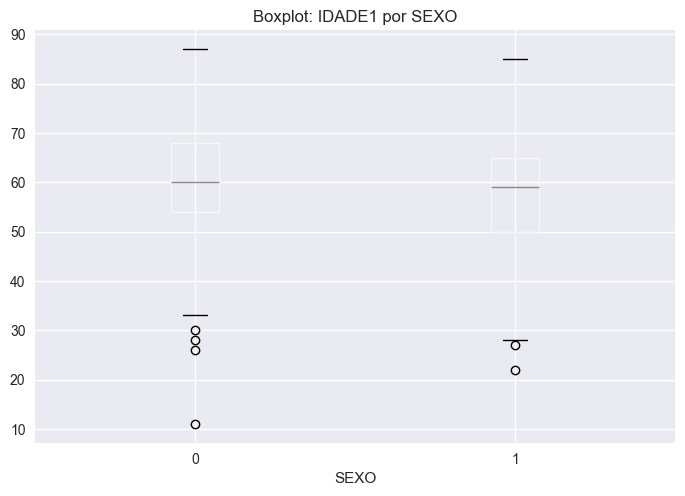


ANOVA: IDADE1 ~ INFARTO
Estatística F: 0.3450
P-value: 0.557216
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                  sum_sq     df         F    PR(>F)
C(INFARTO)     43.832738    1.0  0.345014  0.557216
Residual    63269.055262  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

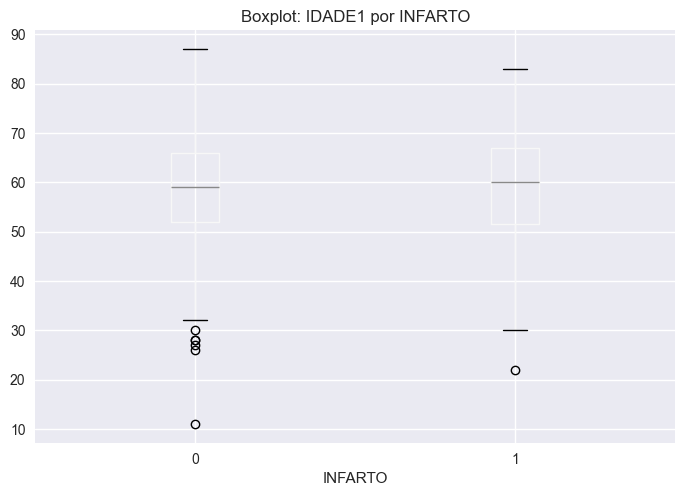


ANOVA: COL ~ GLO
Estatística F: 2.3619
P-value: 0.124970
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                sum_sq     df         F   PR(>F)
C(GLO)    6.390417e+03    1.0  2.361853  0.12497
Residual  1.347429e+06  498.0       NaN      NaN


<Figure size 1000x600 with 0 Axes>

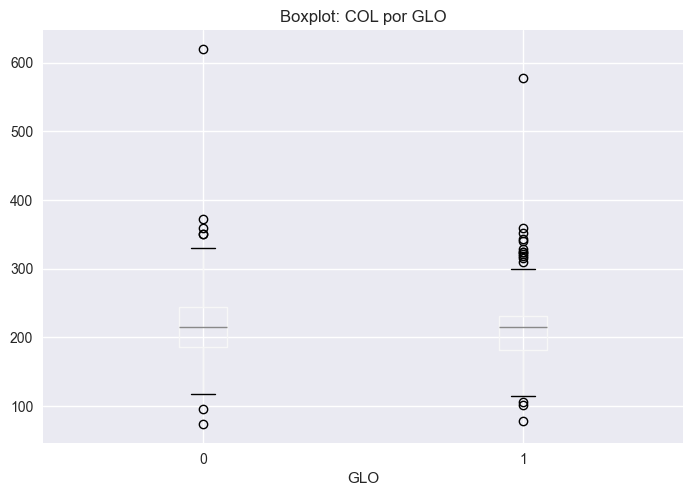


--- Valores Normalizados ---

ANOVA: COL ~ GLO
Estatística F: 2.3619
P-value: 0.124970
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                sum_sq     df         F   PR(>F)
C(GLO)    6.390417e+03    1.0  2.361853  0.12497
Residual  1.347429e+06  498.0       NaN      NaN


<Figure size 1000x600 with 0 Axes>

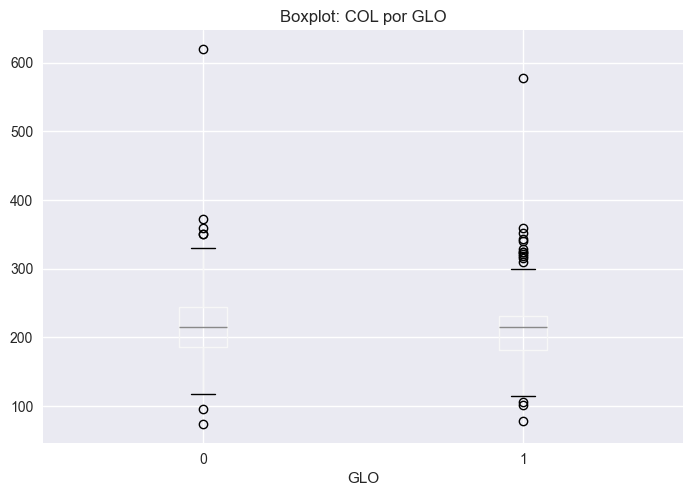


ANOVA: COL ~ ANGEST
Estatística F: 5.1048
P-value: 0.024291
Resultado: Há diferença significativa entre os grupos (p < 0.05)

Tabela ANOVA detalhada:
                 sum_sq     df         F    PR(>F)
C(ANGEST)  1.373670e+04    1.0  5.104817  0.024291
Residual   1.340082e+06  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

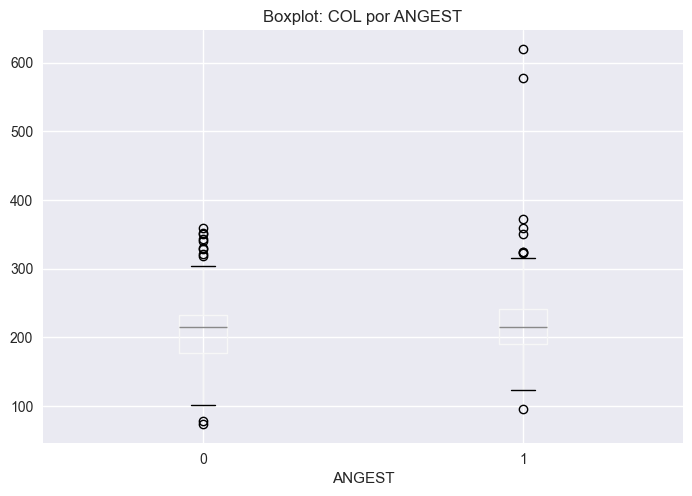


--- Valores Normalizados ---

ANOVA: COL ~ ANGEST
Estatística F: 5.1048
P-value: 0.024291
Resultado: Há diferença significativa entre os grupos (p < 0.05)

Tabela ANOVA detalhada:
                 sum_sq     df         F    PR(>F)
C(ANGEST)  1.373670e+04    1.0  5.104817  0.024291
Residual   1.340082e+06  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

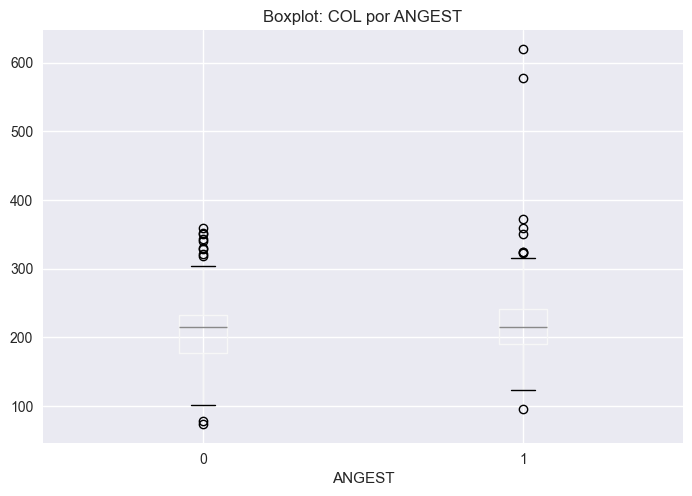


ANOVA: COL ~ OBESO
Estatística F: 0.1279
P-value: 0.720809
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                sum_sq     df         F    PR(>F)
C(OBESO)  3.475094e+02    1.0  0.127864  0.720809
Residual  1.353471e+06  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

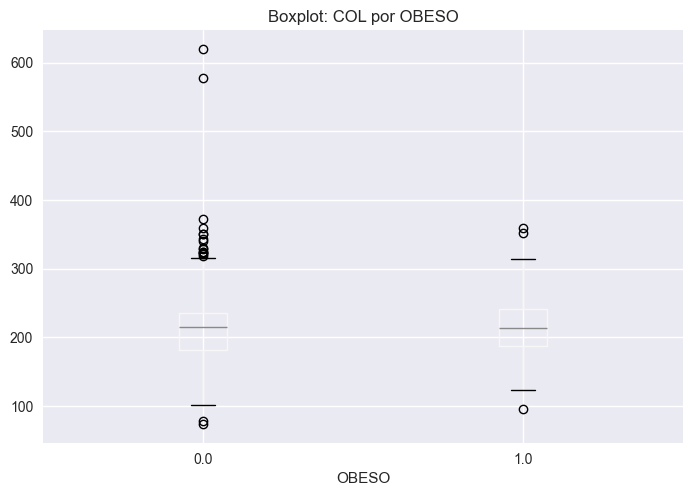


--- Valores Normalizados ---

ANOVA: COL ~ OBESO
Estatística F: 0.1279
P-value: 0.720809
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                sum_sq     df         F    PR(>F)
C(OBESO)  3.475094e+02    1.0  0.127864  0.720809
Residual  1.353471e+06  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

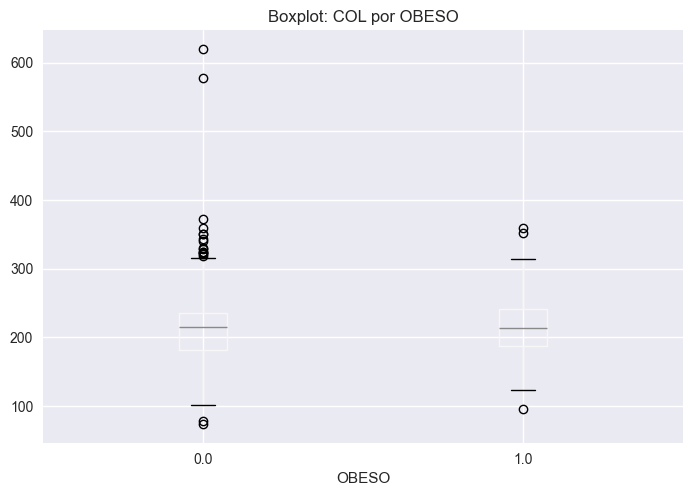


ANOVA: COL ~ DIAB
Estatística F: 0.5989
P-value: 0.439372
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                sum_sq     df         F    PR(>F)
C(DIAB)   1.626110e+03    1.0  0.598881  0.439372
Residual  1.352193e+06  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

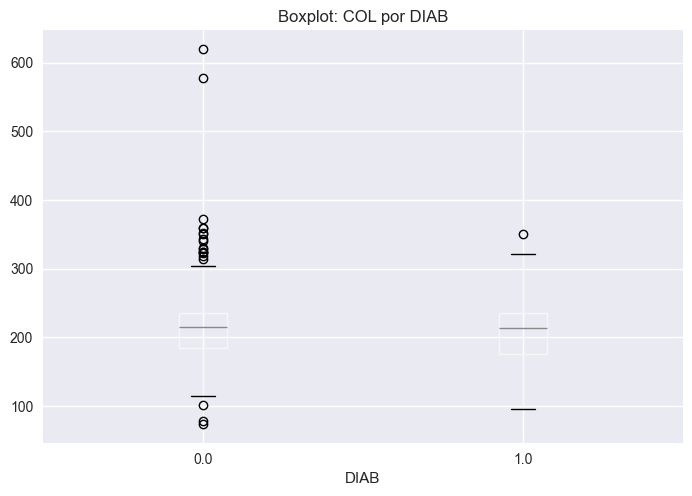


--- Valores Normalizados ---

ANOVA: COL ~ DIAB
Estatística F: 0.5989
P-value: 0.439372
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                sum_sq     df         F    PR(>F)
C(DIAB)   1.626110e+03    1.0  0.598881  0.439372
Residual  1.352193e+06  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

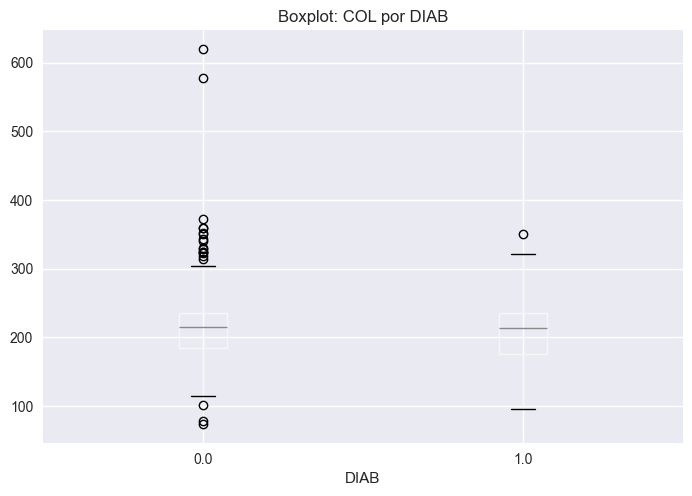


ANOVA: TRIG ~ GLO
Estatística F: 3.0554
P-value: 0.081087
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                sum_sq     df         F    PR(>F)
C(GLO)    2.389625e+04    1.0  3.055365  0.081087
Residual  3.894897e+06  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

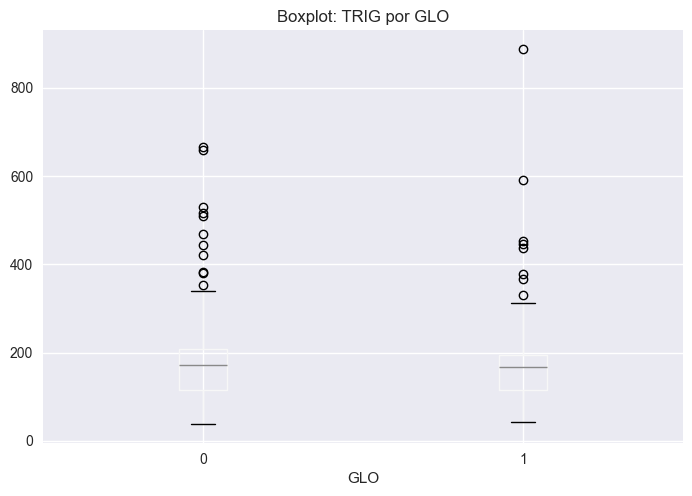


--- Valores Normalizados ---

ANOVA: TRIG ~ GLO
Estatística F: 3.0554
P-value: 0.081087
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                sum_sq     df         F    PR(>F)
C(GLO)    2.389625e+04    1.0  3.055365  0.081087
Residual  3.894897e+06  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

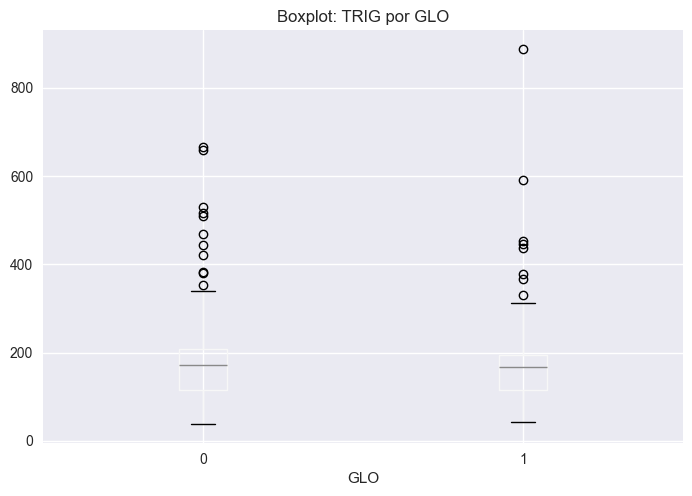


ANOVA: TRIG ~ ANGEST
Estatística F: 1.4426
P-value: 0.230289
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                 sum_sq     df         F    PR(>F)
C(ANGEST)  1.131915e+04    1.0  1.442603  0.230289
Residual   3.907474e+06  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

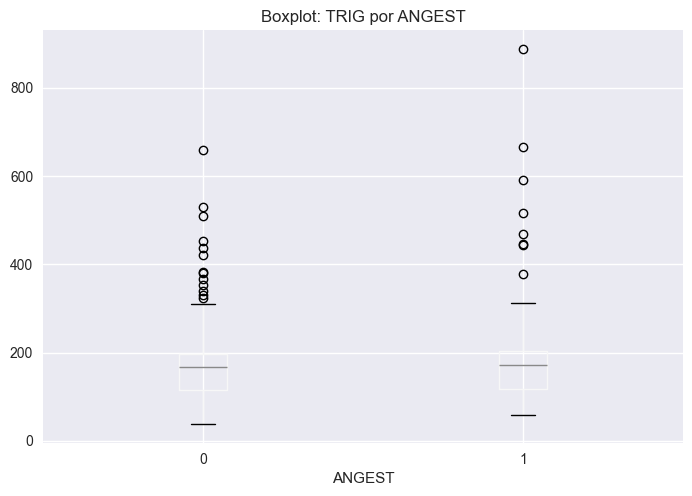


--- Valores Normalizados ---

ANOVA: TRIG ~ ANGEST
Estatística F: 1.4426
P-value: 0.230289
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                 sum_sq     df         F    PR(>F)
C(ANGEST)  1.131915e+04    1.0  1.442603  0.230289
Residual   3.907474e+06  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

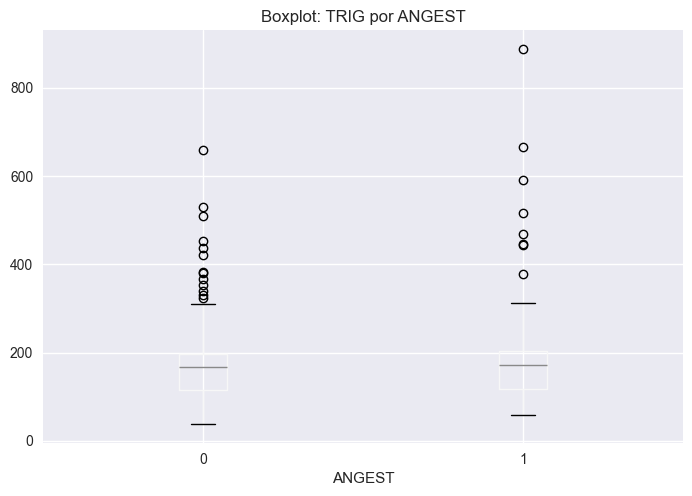


ANOVA: TRIG ~ OBESO
Estatística F: 1.0905
P-value: 0.296870
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                sum_sq     df         F   PR(>F)
C(OBESO)  8.562349e+03    1.0  1.090486  0.29687
Residual  3.910231e+06  498.0       NaN      NaN


<Figure size 1000x600 with 0 Axes>

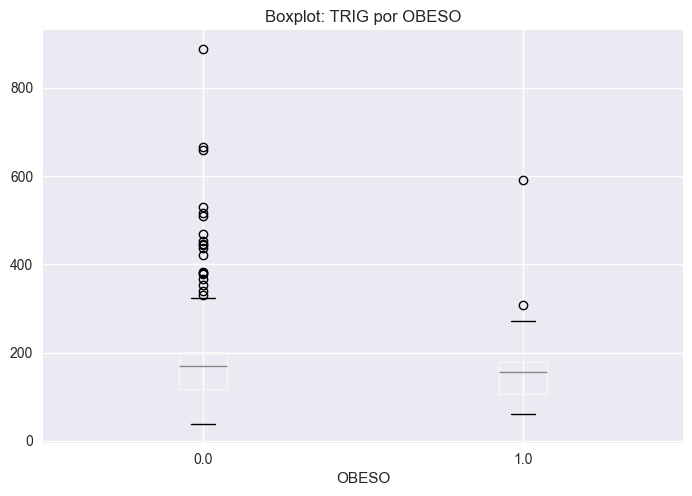


--- Valores Normalizados ---

ANOVA: TRIG ~ OBESO
Estatística F: 1.0905
P-value: 0.296870
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                sum_sq     df         F   PR(>F)
C(OBESO)  8.562349e+03    1.0  1.090486  0.29687
Residual  3.910231e+06  498.0       NaN      NaN


<Figure size 1000x600 with 0 Axes>

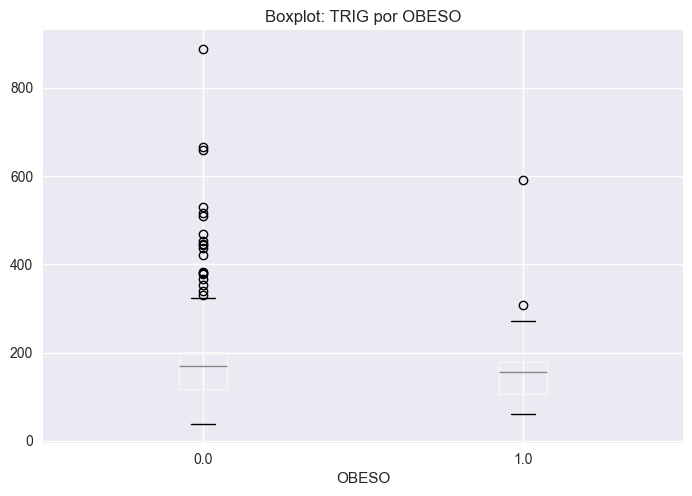


ANOVA: TRIG ~ DIAB
Estatística F: 6.2408
P-value: 0.012805
Resultado: Há diferença significativa entre os grupos (p < 0.05)

Tabela ANOVA detalhada:
                sum_sq     df         F    PR(>F)
C(DIAB)   4.850161e+04    1.0  6.240823  0.012805
Residual  3.870291e+06  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

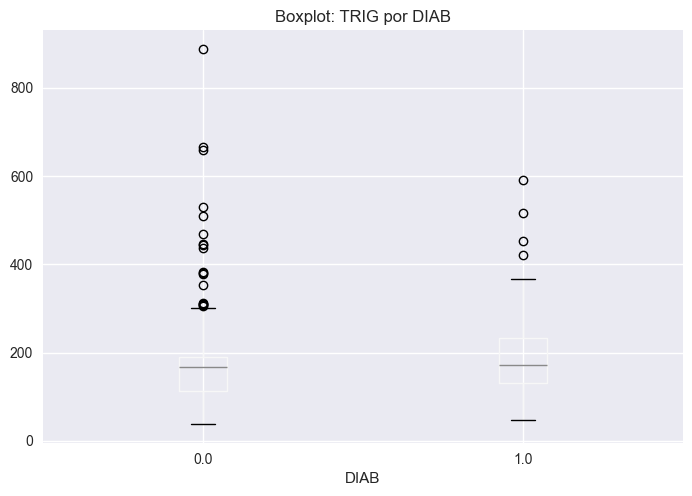


--- Valores Normalizados ---

ANOVA: TRIG ~ DIAB
Estatística F: 6.2408
P-value: 0.012805
Resultado: Há diferença significativa entre os grupos (p < 0.05)

Tabela ANOVA detalhada:
                sum_sq     df         F    PR(>F)
C(DIAB)   4.850161e+04    1.0  6.240823  0.012805
Residual  3.870291e+06  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

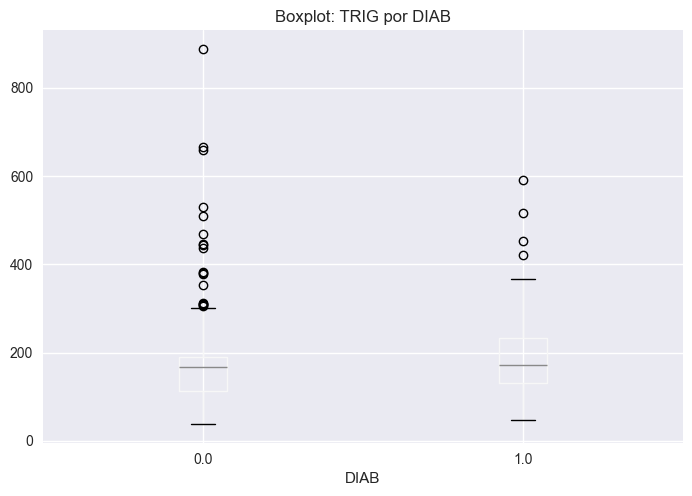


ANOVA: PSR ~ GLO
Estatística F: 0.0356
P-value: 0.850498
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
               sum_sq     df         F    PR(>F)
C(GLO)       0.176070    1.0  0.035563  0.850498
Residual  2465.590529  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

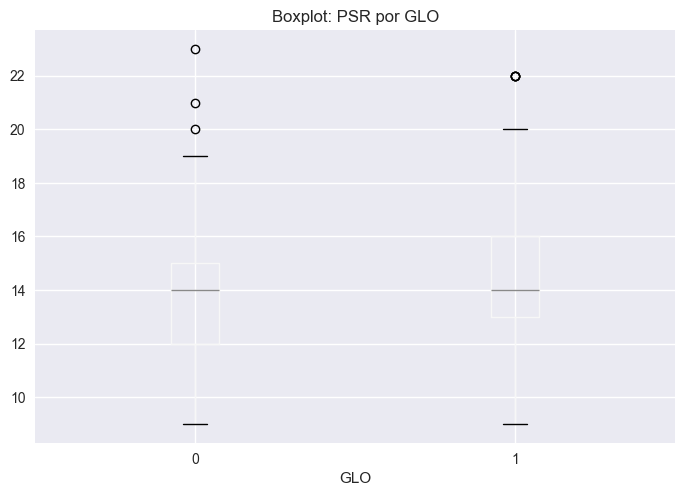


--- Valores Normalizados ---

ANOVA: PSR ~ GLO
Estatística F: 0.0356
P-value: 0.850498
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
               sum_sq     df         F    PR(>F)
C(GLO)       0.176070    1.0  0.035563  0.850498
Residual  2465.590529  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

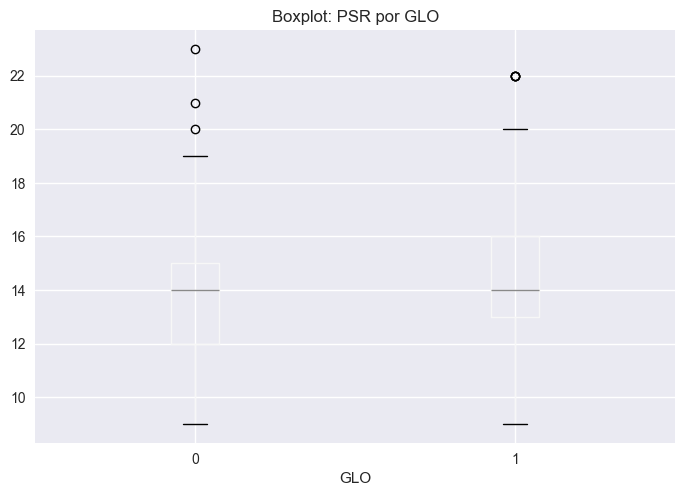


ANOVA: PSR ~ ANGEST
Estatística F: 3.3046
P-value: 0.069687
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
               sum_sq     df         F    PR(>F)
C(ANGEST)    16.25431    1.0  3.304595  0.069687
Residual   2449.51229  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

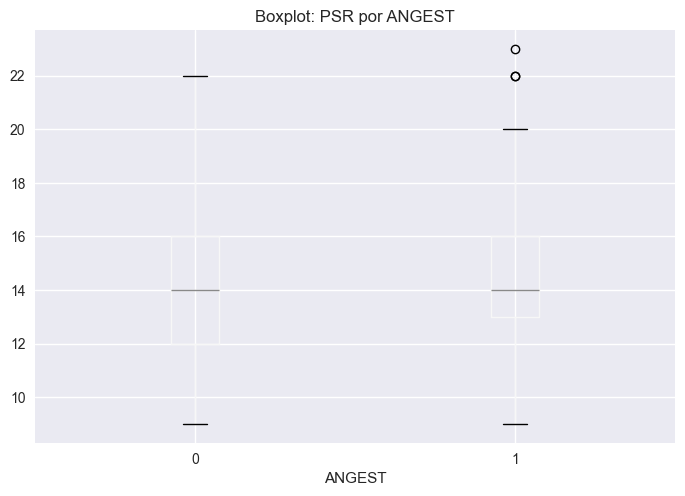


--- Valores Normalizados ---

ANOVA: PSR ~ ANGEST
Estatística F: 3.3046
P-value: 0.069687
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
               sum_sq     df         F    PR(>F)
C(ANGEST)    16.25431    1.0  3.304595  0.069687
Residual   2449.51229  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

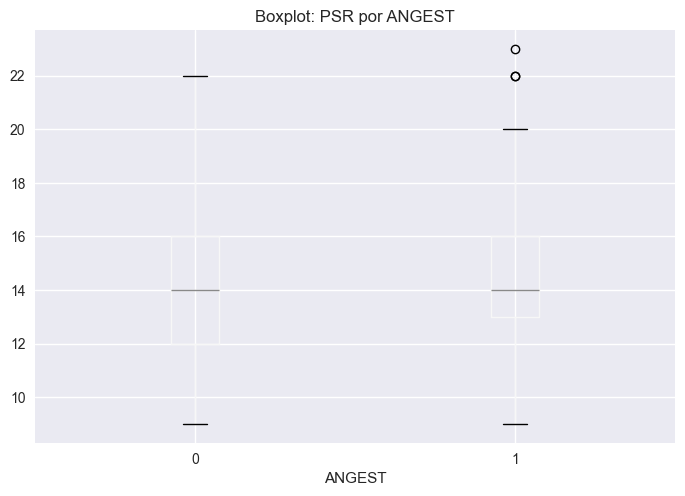


ANOVA: PSR ~ OBESO
Estatística F: 7.5740
P-value: 0.006138
Resultado: Há diferença significativa entre os grupos (p < 0.05)

Tabela ANOVA detalhada:
               sum_sq     df         F    PR(>F)
C(OBESO)    36.939598    1.0  7.573993  0.006138
Residual  2428.827002  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

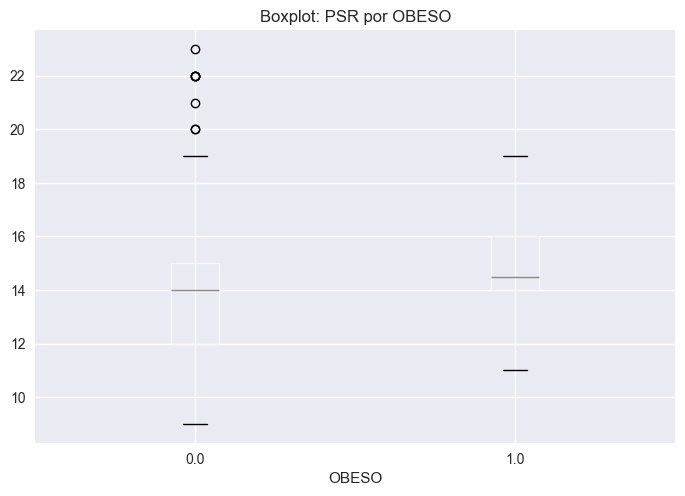


--- Valores Normalizados ---

ANOVA: PSR ~ OBESO
Estatística F: 7.5740
P-value: 0.006138
Resultado: Há diferença significativa entre os grupos (p < 0.05)

Tabela ANOVA detalhada:
               sum_sq     df         F    PR(>F)
C(OBESO)    36.939598    1.0  7.573993  0.006138
Residual  2428.827002  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

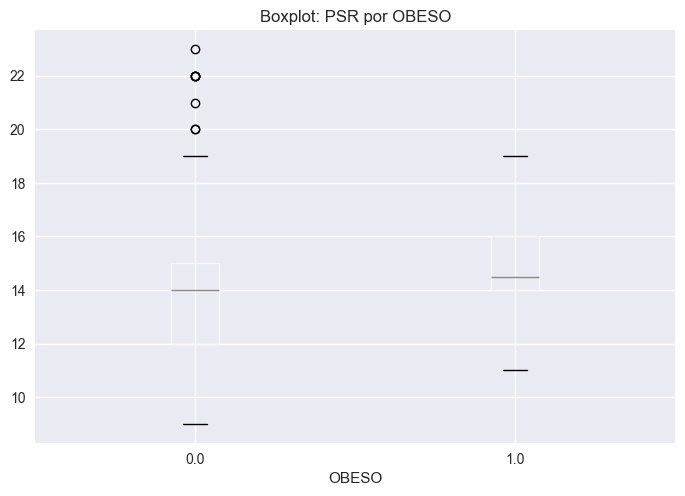


ANOVA: PSR ~ DIAB
Estatística F: 4.5223
P-value: 0.033947
Resultado: Há diferença significativa entre os grupos (p < 0.05)

Tabela ANOVA detalhada:
               sum_sq     df        F    PR(>F)
C(DIAB)     22.189884    1.0  4.52229  0.033947
Residual  2443.576716  498.0      NaN       NaN


<Figure size 1000x600 with 0 Axes>

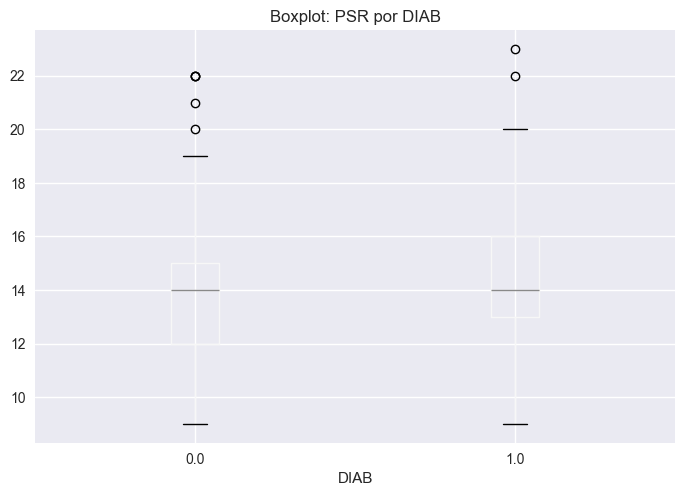


--- Valores Normalizados ---

ANOVA: PSR ~ DIAB
Estatística F: 4.5223
P-value: 0.033947
Resultado: Há diferença significativa entre os grupos (p < 0.05)

Tabela ANOVA detalhada:
               sum_sq     df        F    PR(>F)
C(DIAB)     22.189884    1.0  4.52229  0.033947
Residual  2443.576716  498.0      NaN       NaN


<Figure size 1000x600 with 0 Axes>

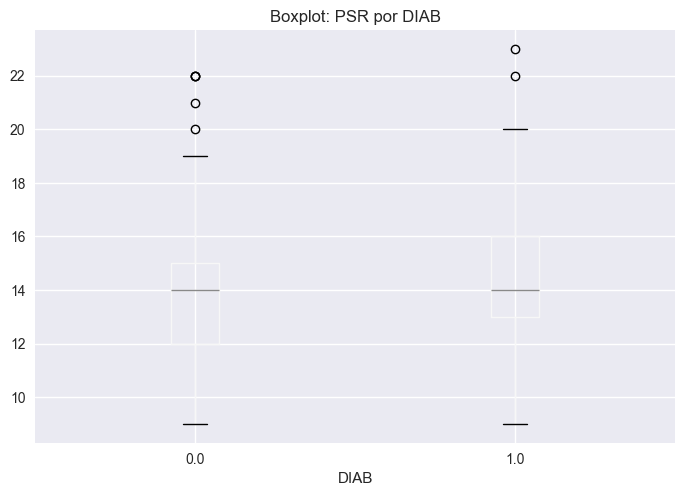


ANOVA: PDR ~ GLO
Estatística F: 0.0540
P-value: 0.816402
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
              sum_sq     df         F    PR(>F)
C(GLO)      0.070016    1.0  0.053962  0.816402
Residual  646.155336  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

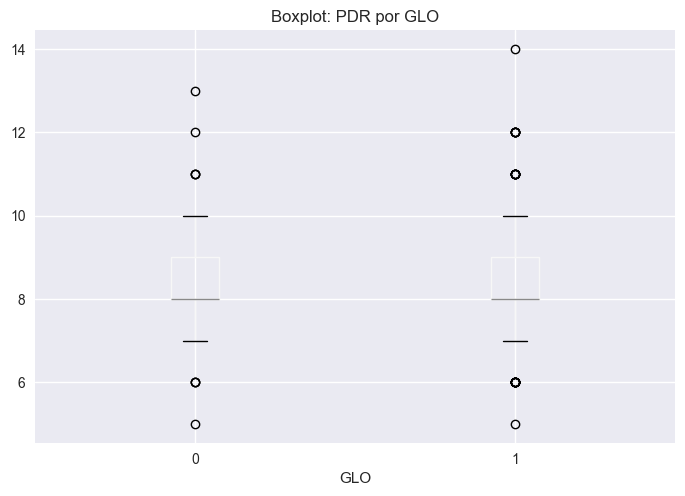


--- Valores Normalizados ---

ANOVA: PDR ~ GLO
Estatística F: 0.0540
P-value: 0.816402
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
              sum_sq     df         F    PR(>F)
C(GLO)      0.070016    1.0  0.053962  0.816402
Residual  646.155336  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

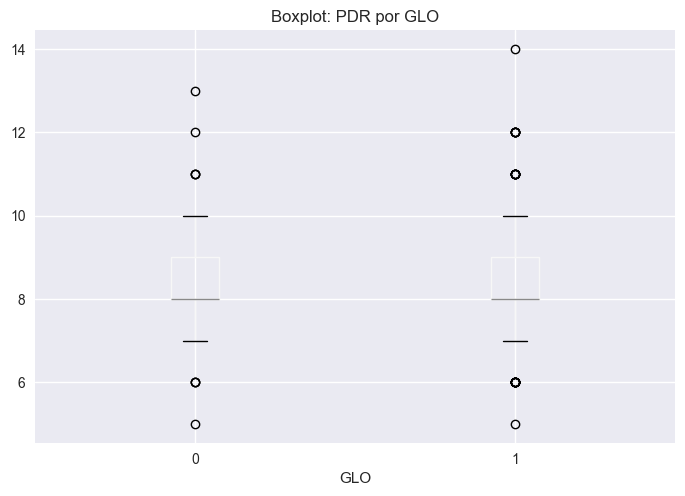


ANOVA: PDR ~ ANGEST
Estatística F: 3.5310
P-value: 0.060815
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
               sum_sq     df         F    PR(>F)
C(ANGEST)    4.549727    1.0  3.531011  0.060815
Residual   641.675625  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

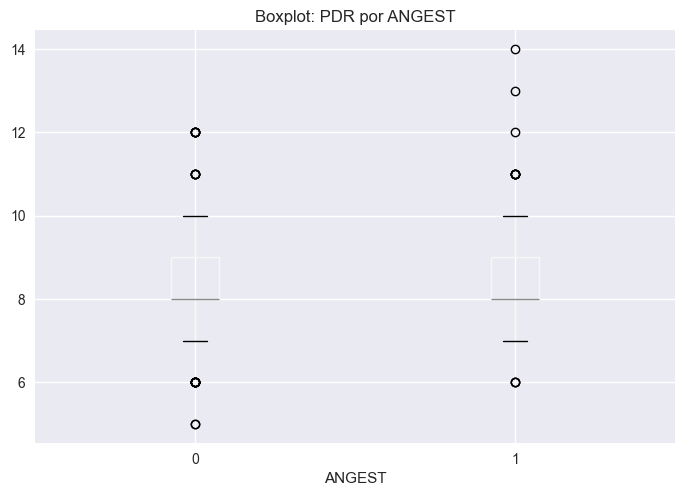


--- Valores Normalizados ---

ANOVA: PDR ~ ANGEST
Estatística F: 3.5310
P-value: 0.060815
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
               sum_sq     df         F    PR(>F)
C(ANGEST)    4.549727    1.0  3.531011  0.060815
Residual   641.675625  498.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

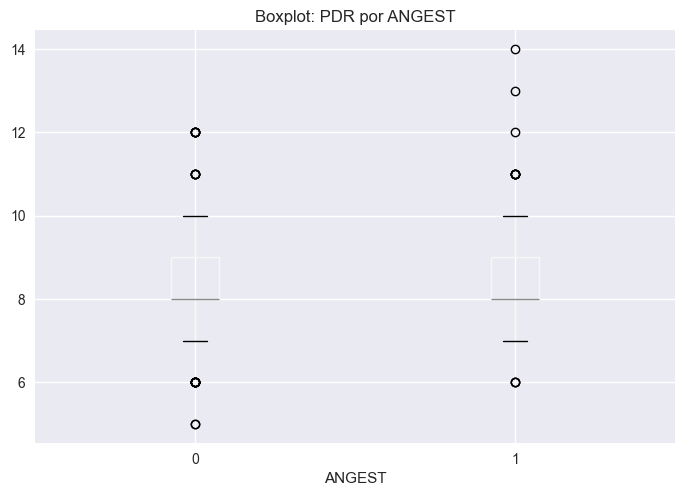


ANOVA: PDR ~ OBESO
Estatística F: 10.2435
P-value: 0.001459
Resultado: Há diferença significativa entre os grupos (p < 0.05)

Tabela ANOVA detalhada:
              sum_sq     df          F    PR(>F)
C(OBESO)   13.024477    1.0  10.243494  0.001459
Residual  633.200875  498.0        NaN       NaN


<Figure size 1000x600 with 0 Axes>

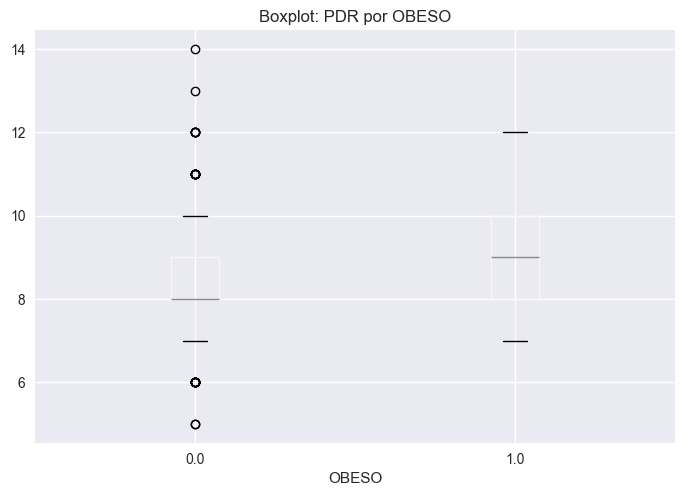


--- Valores Normalizados ---

ANOVA: PDR ~ OBESO
Estatística F: 10.2435
P-value: 0.001459
Resultado: Há diferença significativa entre os grupos (p < 0.05)

Tabela ANOVA detalhada:
              sum_sq     df          F    PR(>F)
C(OBESO)   13.024477    1.0  10.243494  0.001459
Residual  633.200875  498.0        NaN       NaN


<Figure size 1000x600 with 0 Axes>

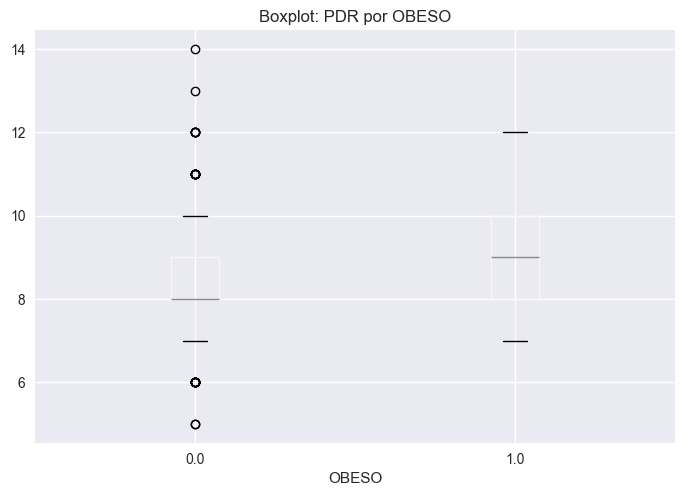


ANOVA: PDR ~ DIAB
Estatística F: 0.0018
P-value: 0.965806
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
              sum_sq     df        F    PR(>F)
C(DIAB)     0.002387    1.0  0.00184  0.965806
Residual  646.222965  498.0      NaN       NaN


<Figure size 1000x600 with 0 Axes>

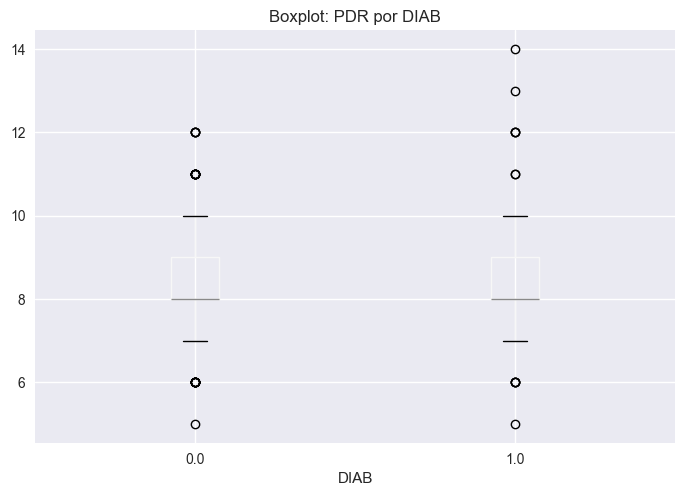


--- Valores Normalizados ---

ANOVA: PDR ~ DIAB
Estatística F: 0.0018
P-value: 0.965806
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
              sum_sq     df        F    PR(>F)
C(DIAB)     0.002387    1.0  0.00184  0.965806
Residual  646.222965  498.0      NaN       NaN


<Figure size 1000x600 with 0 Axes>

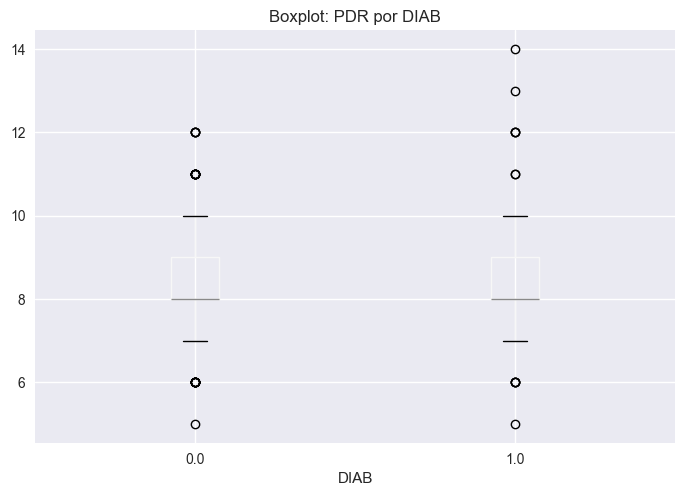


ANOVA: PDR ~ AH3
Estatística F: 0.1096
P-value: 0.896222
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
              sum_sq     df         F    PR(>F)
C(AH3)      0.284867    2.0  0.109591  0.896222
Residual  645.940485  497.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

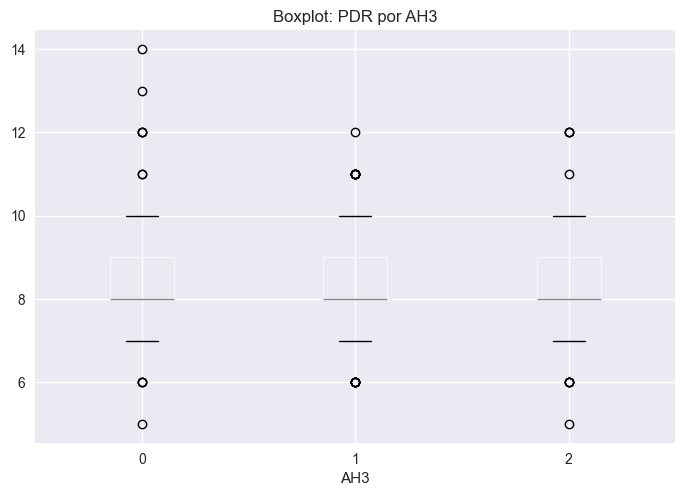


--- Valores Normalizados ---

ANOVA: PDR ~ AH3
Estatística F: 0.1096
P-value: 0.896222
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
              sum_sq     df         F    PR(>F)
C(AH3)      0.284867    2.0  0.109591  0.896222
Residual  645.940485  497.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

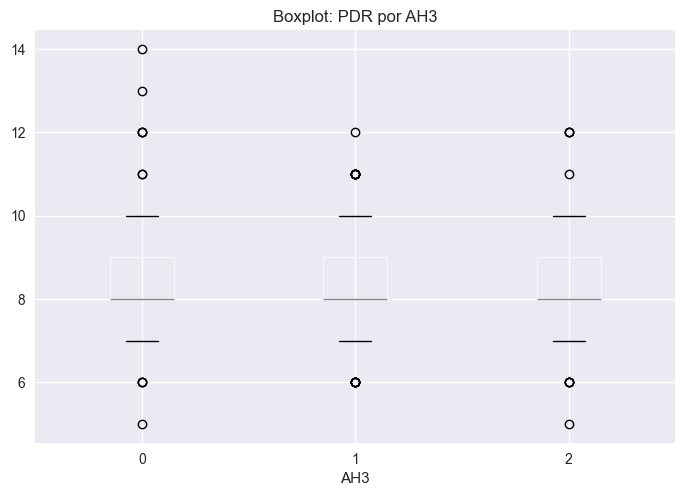


ANOVA: PDR ~ TABAG4
Estatística F: 1.2175
P-value: 0.299607
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
               sum_sq     df         F    PR(>F)
C(TABAG4)    7.866296    5.0  1.217481  0.299607
Residual   638.359056  494.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

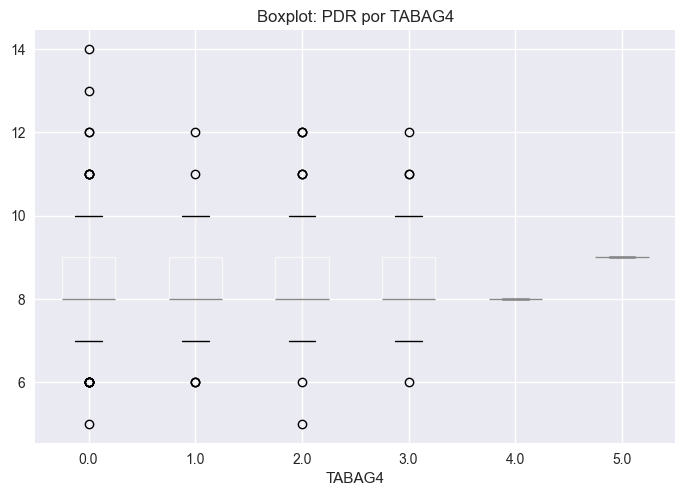


--- Valores Normalizados ---

ANOVA: PDR ~ TABAG4
Estatística F: 1.2175
P-value: 0.299607
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
               sum_sq     df         F    PR(>F)
C(TABAG4)    7.866296    5.0  1.217481  0.299607
Residual   638.359056  494.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

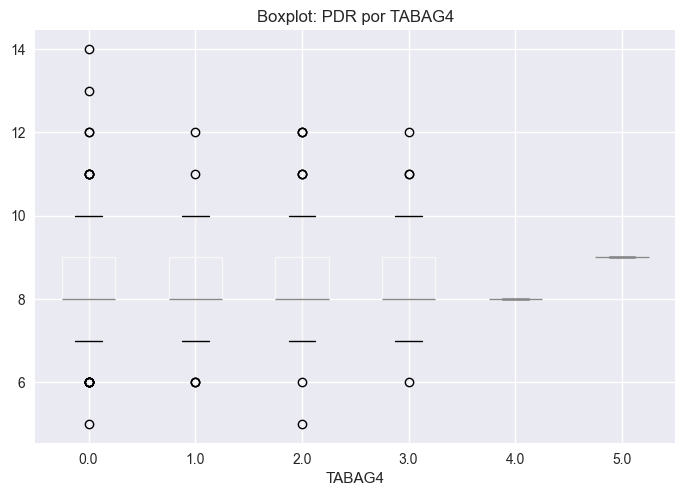


ANOVA: PSR ~ AH3
Estatística F: 0.6334
P-value: 0.531208
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
               sum_sq     df         F    PR(>F)
C(AH3)       6.269079    2.0  0.633408  0.531208
Residual  2459.497520  497.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

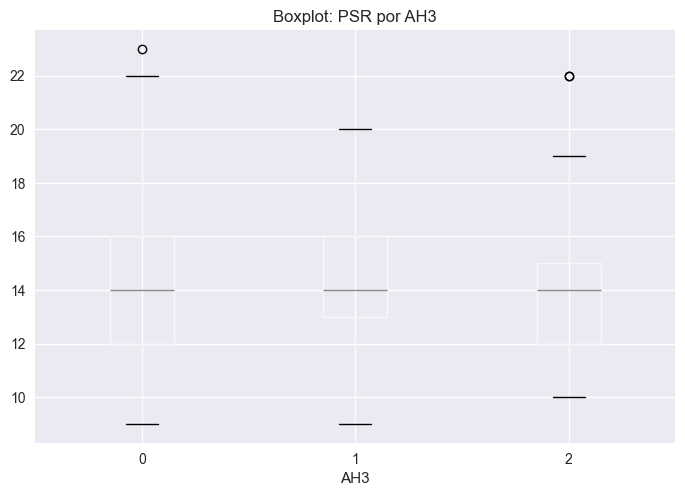


--- Valores Normalizados ---

ANOVA: PSR ~ AH3
Estatística F: 0.6334
P-value: 0.531208
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
               sum_sq     df         F    PR(>F)
C(AH3)       6.269079    2.0  0.633408  0.531208
Residual  2459.497520  497.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

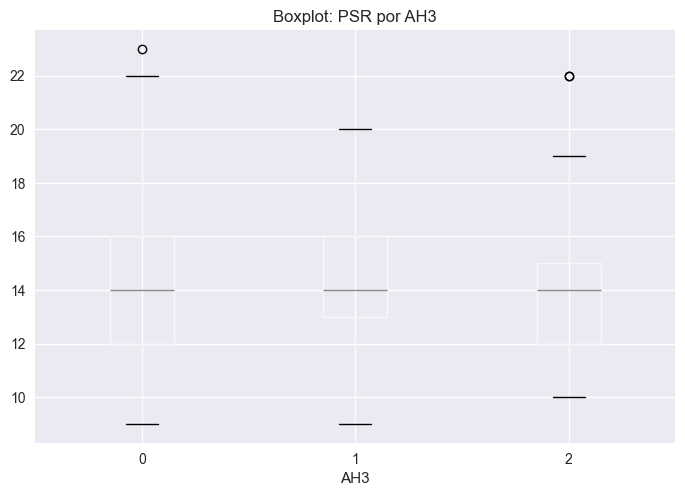


ANOVA: PSR ~ TABAG4
Estatística F: 3.2984
P-value: 0.006110
Resultado: Há diferença significativa entre os grupos (p < 0.05)

Tabela ANOVA detalhada:
                sum_sq     df       F   PR(>F)
C(TABAG4)    79.659271    5.0  3.2984  0.00611
Residual   2386.107328  494.0     NaN      NaN


<Figure size 1000x600 with 0 Axes>

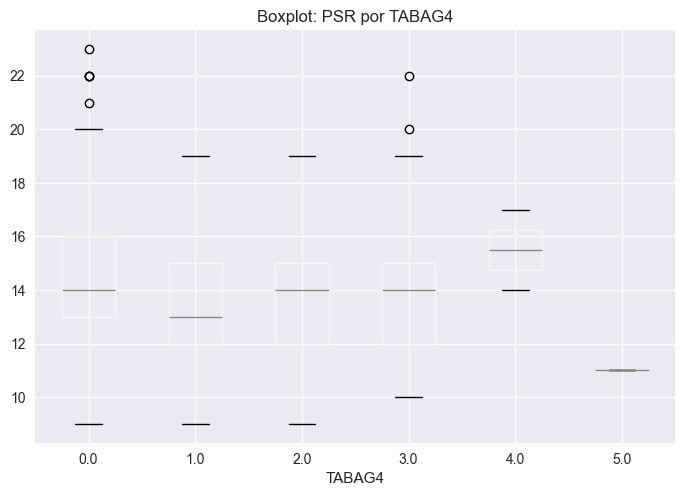


--- Valores Normalizados ---

ANOVA: PSR ~ TABAG4
Estatística F: 3.2984
P-value: 0.006110
Resultado: Há diferença significativa entre os grupos (p < 0.05)

Tabela ANOVA detalhada:
                sum_sq     df       F   PR(>F)
C(TABAG4)    79.659271    5.0  3.2984  0.00611
Residual   2386.107328  494.0     NaN      NaN


<Figure size 1000x600 with 0 Axes>

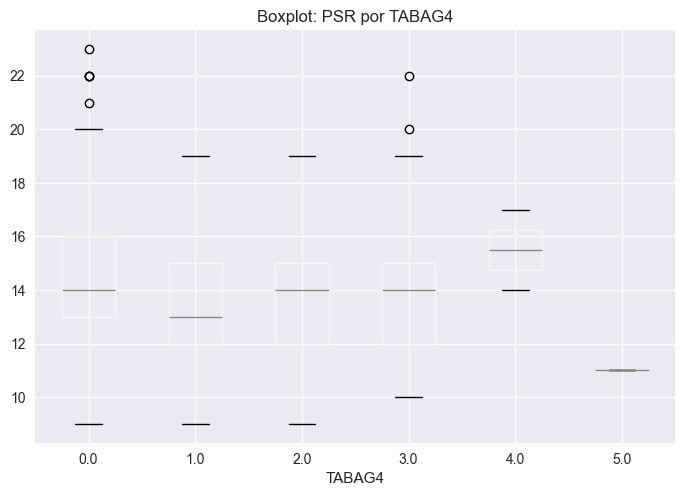


ANOVA: COL ~ AH3
Estatística F: 2.0985
P-value: 0.123726
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                sum_sq     df         F    PR(>F)
C(AH3)    1.133679e+04    2.0  2.098495  0.123726
Residual  1.342482e+06  497.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

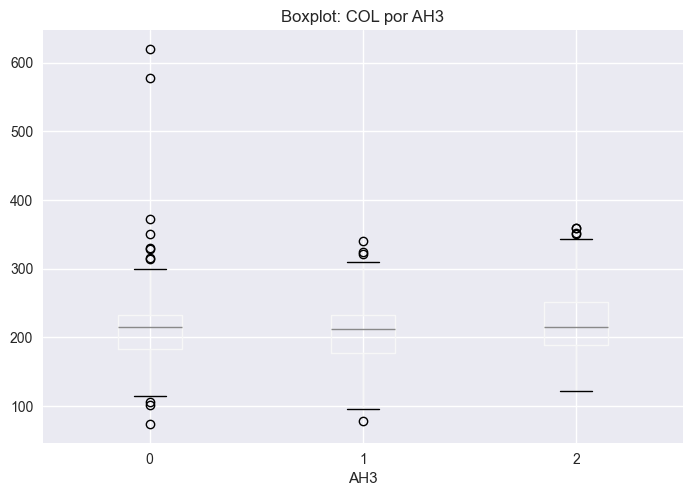


--- Valores Normalizados ---

ANOVA: COL ~ AH3
Estatística F: 2.0985
P-value: 0.123726
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                sum_sq     df         F    PR(>F)
C(AH3)    1.133679e+04    2.0  2.098495  0.123726
Residual  1.342482e+06  497.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

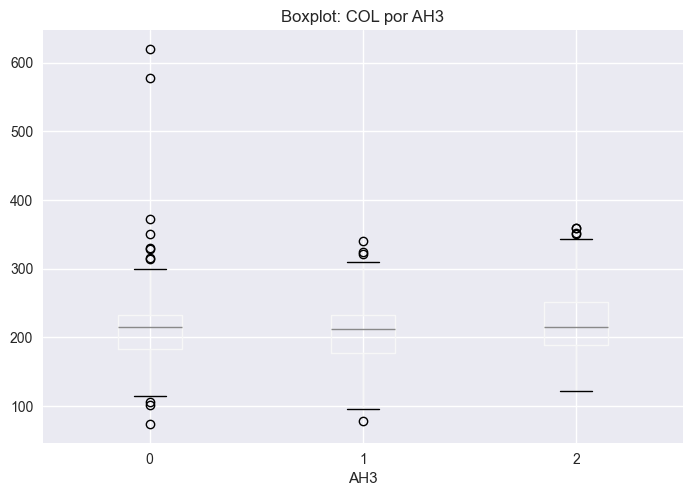


ANOVA: COL ~ TABAG4
Estatística F: 1.2289
P-value: 0.294254
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                 sum_sq     df         F    PR(>F)
C(TABAG4)  1.663176e+04    5.0  1.228862  0.294254
Residual   1.337187e+06  494.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

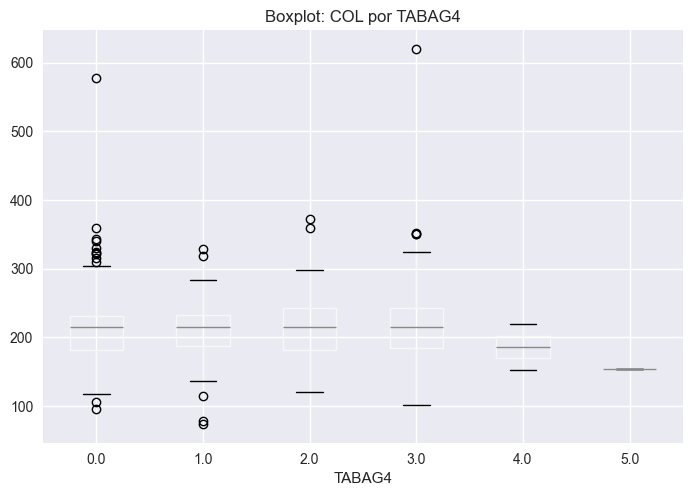


--- Valores Normalizados ---

ANOVA: COL ~ TABAG4
Estatística F: 1.2289
P-value: 0.294254
Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)

Tabela ANOVA detalhada:
                 sum_sq     df         F    PR(>F)
C(TABAG4)  1.663176e+04    5.0  1.228862  0.294254
Residual   1.337187e+06  494.0       NaN       NaN


<Figure size 1000x600 with 0 Axes>

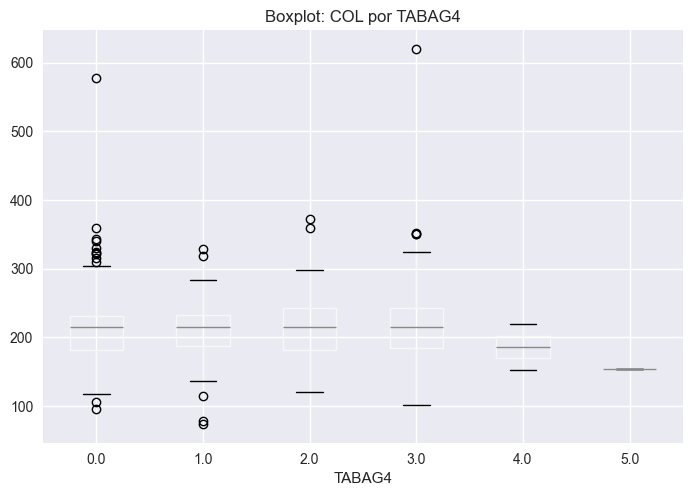

In [253]:
def realizar_anova(df, var_dependente, var_independente, post_hoc=False):
    """
    Realiza ANOVA unifatorial com teste post-hoc opcional
    
    Parâmetros:
    - df: DataFrame
    - var_dependente: nome da variável dependente (numérica)
    - var_independente: nome da variável independente (categórica)
    - post_hoc: se True, realiza teste de Tukey
    """
    
    print(f"\nANOVA: {var_dependente} ~ {var_independente}")
    
    # Preparando os grupos
    grupos = [group[var_dependente].values for name, group in df.groupby(var_independente)]
    
    # ANOVA usando scipy
    f_stat, p_value = f_oneway(*grupos)
    
    print(f"Estatística F: {f_stat:.4f}")
    print(f"P-value: {p_value:.6f}")
    
    if p_value < 0.05:
        print("Resultado: Há diferença significativa entre os grupos (p < 0.05)")
    else:
        print("Resultado: Não há diferença significativa entre os grupos (p ≥ 0.05)")
    
    # ANOVA usando statsmodels (mais detalhada)
    formula = f"{var_dependente} ~ C({var_independente})"
    model = ols(formula, data=df).fit()
    anova_table = anova_lm(model, typ=2)
    
    print(f"\nTabela ANOVA detalhada:")
    print(anova_table)
    
    # Teste post-hoc (Tukey HSD)
    if post_hoc and p_value < 0.05:
        print(f"\nTeste Post-hoc (Tukey HSD):")
        tukey = pairwise_tukeyhsd(df[var_dependente], df[var_independente], alpha=0.05)
        print(tukey)
    
    # Visualização
    plt.figure(figsize=(10, 6))
    df.boxplot(column=var_dependente, by=var_independente)
    plt.title(f'Boxplot: {var_dependente} por {var_independente}')
    plt.suptitle('')
    plt.show()
    
    return model, anova_table

# Executando ANOVA para cada variável dependente
for var_dep in an1_dep:
    for var_indep in an1_indep:
        modelo_anova, tabela_anova = realizar_anova(data, var_dep, var_indep)
        
for var_dep in an2_dep:
    for var_indep in an2_indep:
        modelo_anova, tabela_anova = realizar_anova(data, var_dep, var_indep)
        print("\n--- Valores Normalizados ---")
        modelo_anova, tabela_anova = realizar_anova(df, var_dep, var_indep)
for var_dep in an3_dep:
    for var_indep in an3_indep:
        modelo_anova, tabela_anova = realizar_anova(data, var_dep, var_indep)
        print("\n--- Valores Normalizados ---")
        modelo_anova, tabela_anova = realizar_anova(df, var_dep, var_indep)


In [254]:
#Análise 4: A obesidade, a arteriopatia e o Grau de Lesão Obstrutiva (GLO) estão associados a níveis elevados de Triglicerídeos
an4_dep = ['TRIG']
an4_indep = ['OBESO', 'ARTER', 'GLO']

#Análise 5: Quais variáveis (Triglicerídeos, IMC, Sexo e Tabagismo) são os melhores preditores do nível de Colesterol?
an5_dep = ['COL']
an5_indep = ['TRIG', 'IMC', 'SEXO', 'TABAG4']

#Análise 6: Qual é o efeito combinado da idade, da presença de diabetes e da arritmia na Pressão Sistólica e Diastólica?
an6_dep = ['PSR', 'PDR']
an6_indep = ['IDADE1', 'DIAB', 'ARRIT']


--- Regressões Simples ---

Regressão Simples: TRIG ~ OBESO

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                   TRIG   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.090
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.297
Time:                        17:09:42   Log-Likelihood:                -2950.6
No. Observations:                 500   AIC:                             5905.
Df Residuals:                     498   BIC:                             5914.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

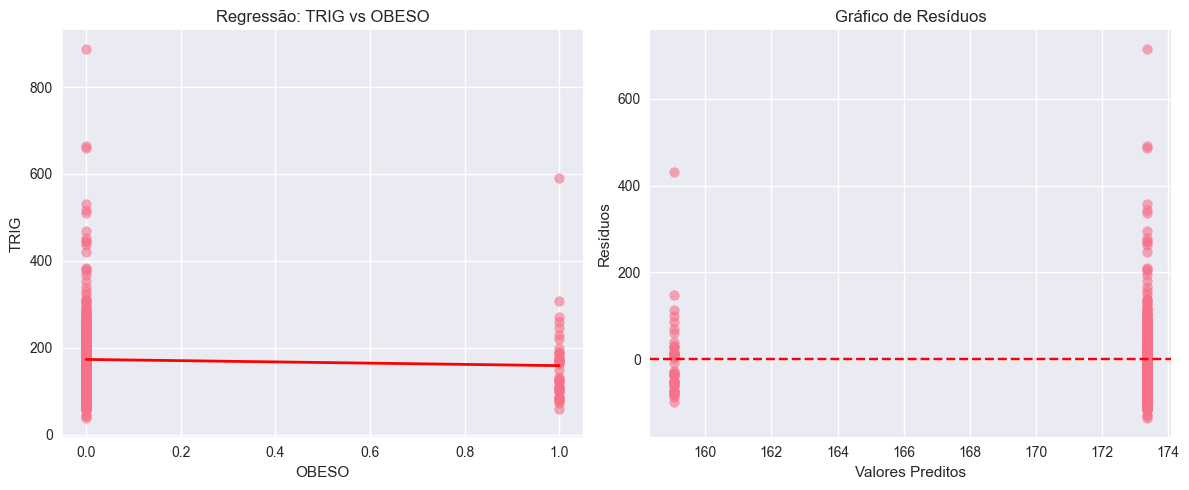


--- Valores Normalizados ---

Regressão Simples: TRIG ~ OBESO

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                   TRIG   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.090
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.297
Time:                        17:09:43   Log-Likelihood:                -2950.6
No. Observations:                 500   AIC:                             5905.
Df Residuals:                     498   BIC:                             5914.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

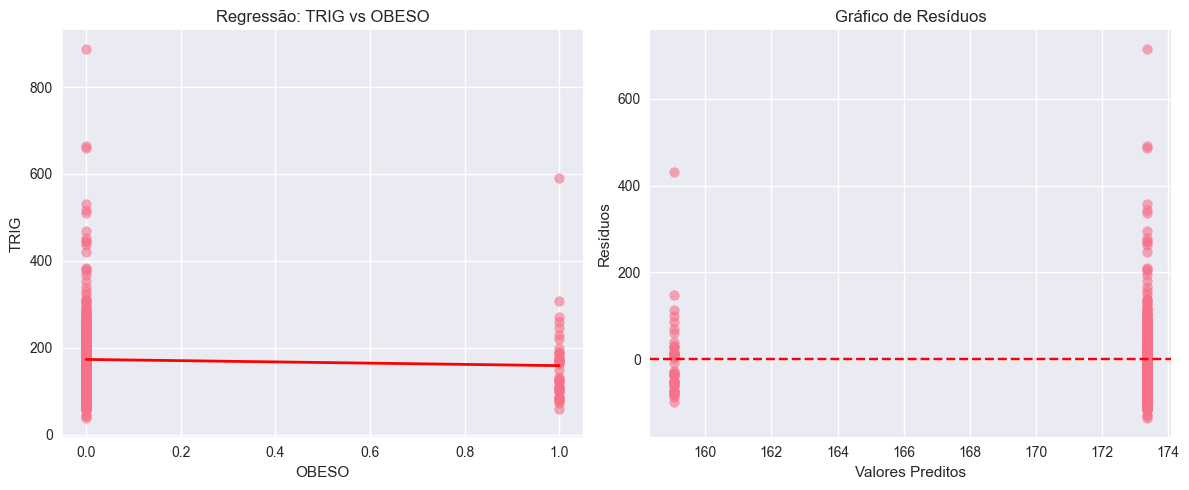


Regressão Simples: TRIG ~ ARTER

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                   TRIG   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5493
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.459
Time:                        17:09:44   Log-Likelihood:                -2950.9
No. Observations:                 500   AIC:                             5906.
Df Residuals:                     498   BIC:                             5914.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


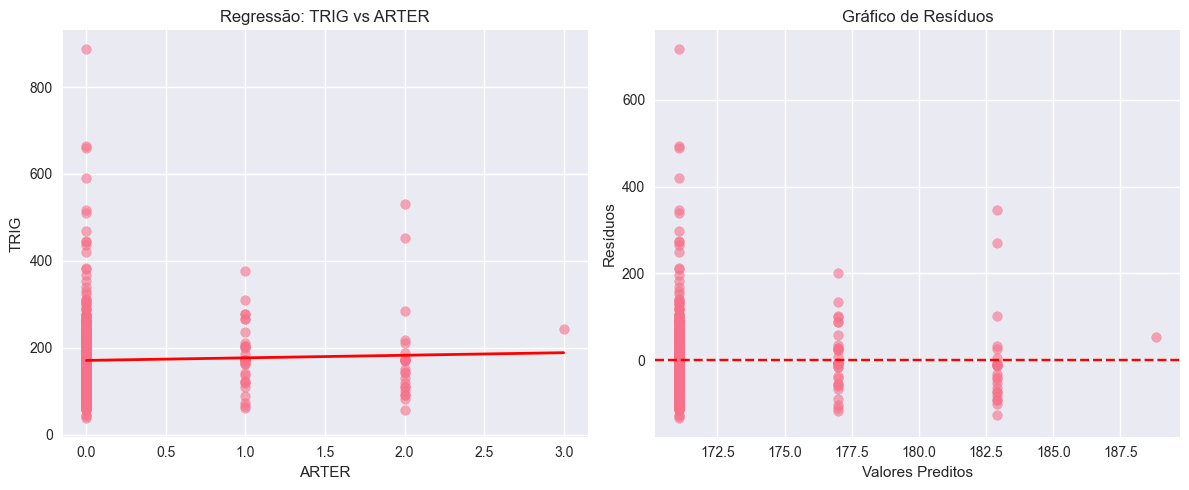


--- Valores Normalizados ---

Regressão Simples: TRIG ~ ARTER

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                   TRIG   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5493
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.459
Time:                        17:09:44   Log-Likelihood:                -2950.9
No. Observations:                 500   AIC:                             5906.
Df Residuals:                     498   BIC:                             5914.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

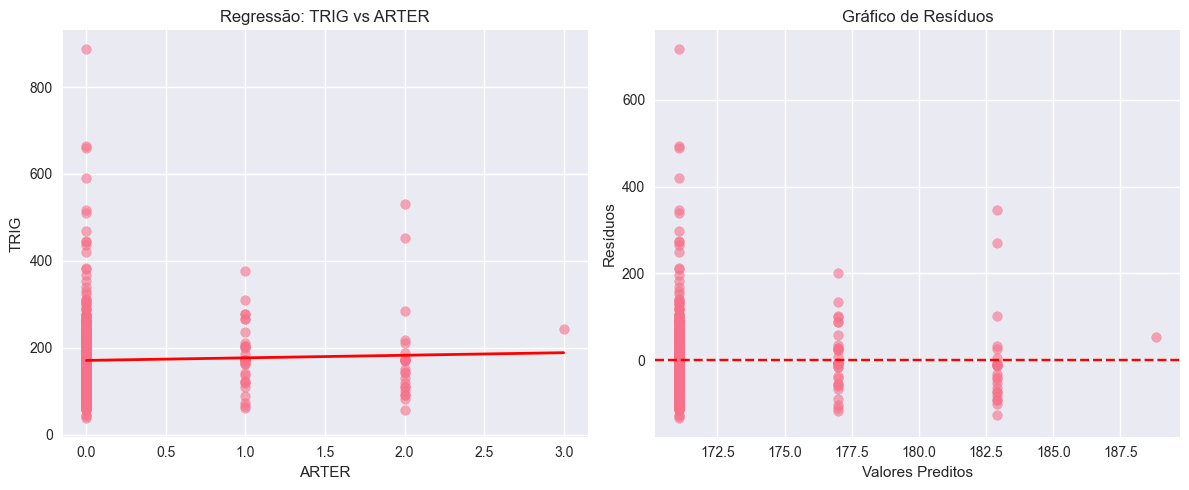


Regressão Simples: TRIG ~ GLO

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                   TRIG   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.055
Date:                Sun, 28 Sep 2025   Prob (F-statistic):             0.0811
Time:                        17:09:45   Log-Likelihood:                -2949.6
No. Observations:                 500   AIC:                             5903.
Df Residuals:                     498   BIC:                             5912.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

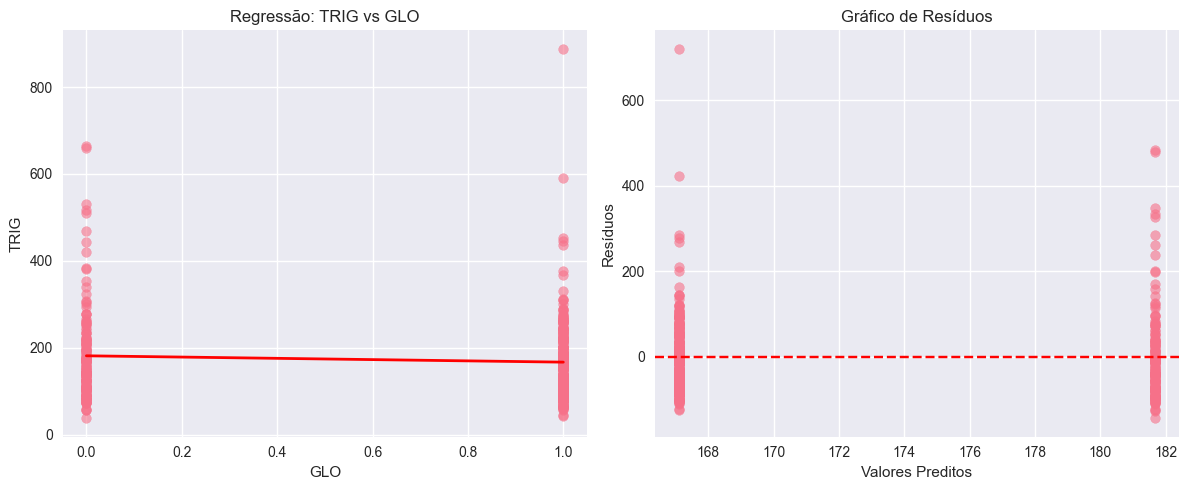


--- Valores Normalizados ---

Regressão Simples: TRIG ~ GLO

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                   TRIG   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.055
Date:                Sun, 28 Sep 2025   Prob (F-statistic):             0.0811
Time:                        17:09:46   Log-Likelihood:                -2949.6
No. Observations:                 500   AIC:                             5903.
Df Residuals:                     498   BIC:                             5912.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

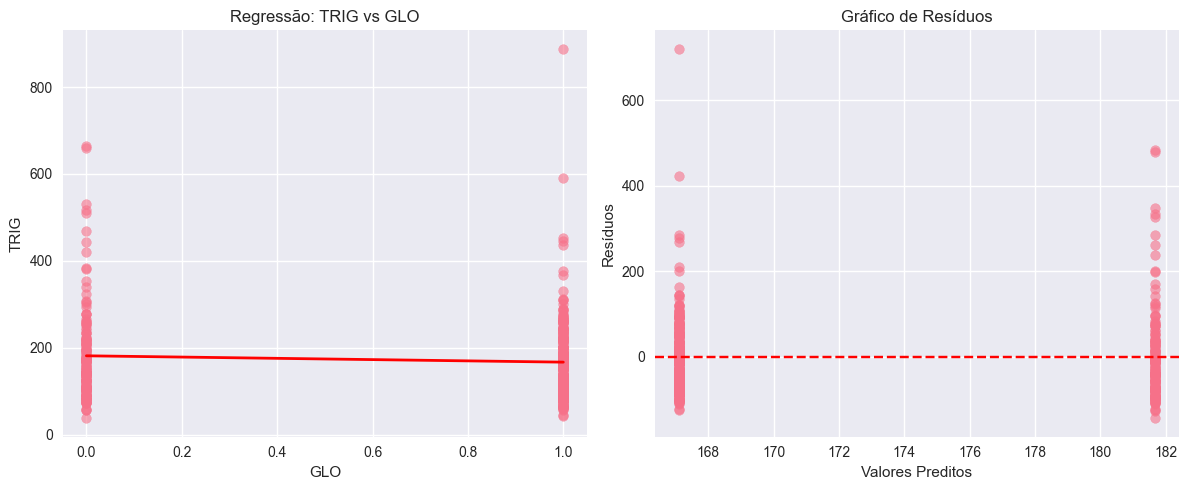


Regressão Simples: COL ~ TRIG

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    COL   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     111.8
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           1.02e-23
Time:                        17:09:46   Log-Likelihood:                -2634.8
No. Observations:                 500   AIC:                             5274.
Df Residuals:                     498   BIC:                             5282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

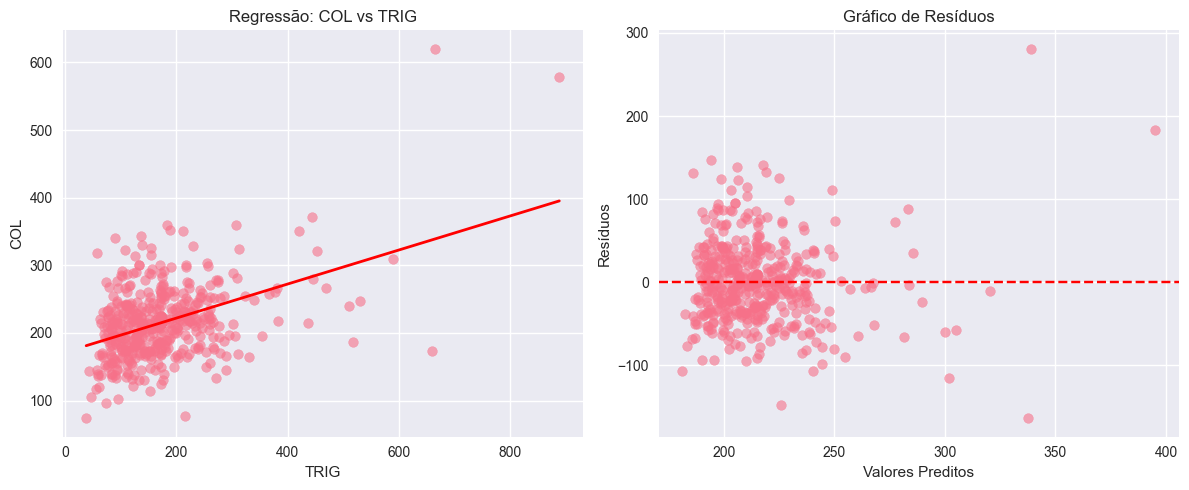


--- Valores Normalizados ---

Regressão Simples: COL ~ TRIG

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    COL   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     111.8
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           1.02e-23
Time:                        17:09:47   Log-Likelihood:                -2634.8
No. Observations:                 500   AIC:                             5274.
Df Residuals:                     498   BIC:                             5282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

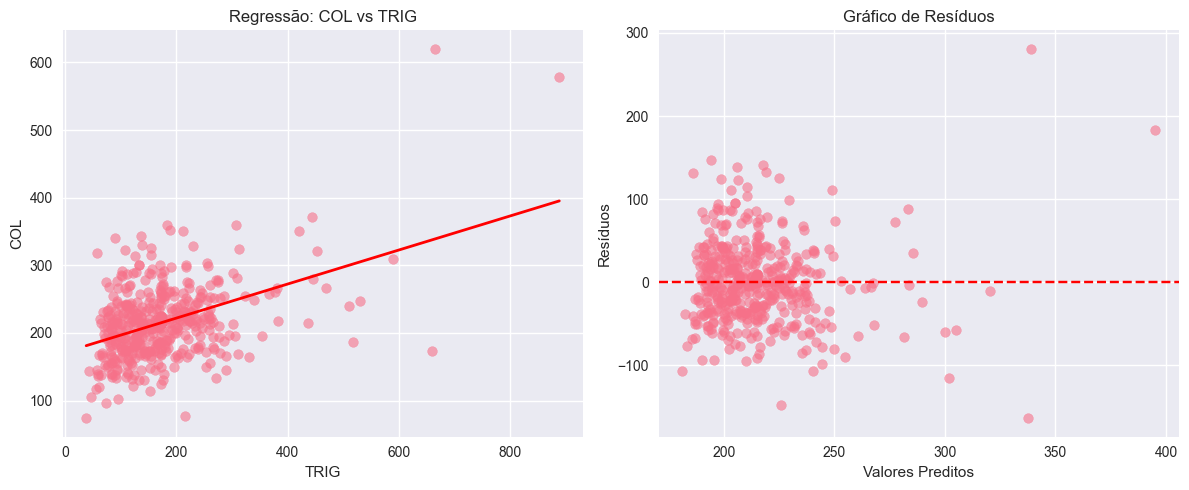


Regressão Simples: COL ~ IMC

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    COL   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.788
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.182
Time:                        17:09:47   Log-Likelihood:                -2684.5
No. Observations:                 500   AIC:                             5373.
Df Residuals:                     498   BIC:                             5381.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

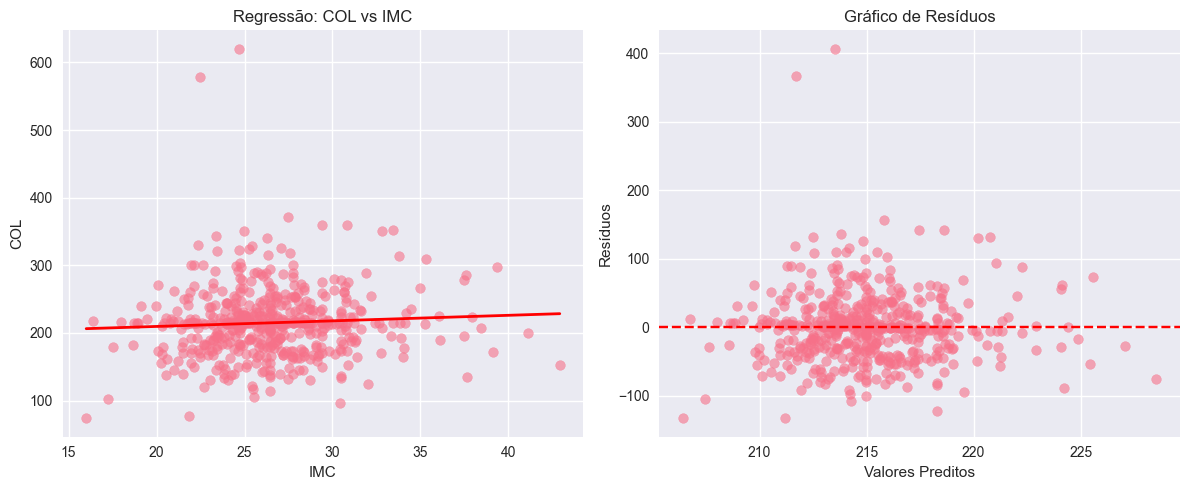


--- Valores Normalizados ---

Regressão Simples: COL ~ IMC

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    COL   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.788
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.182
Time:                        17:09:48   Log-Likelihood:                -2684.5
No. Observations:                 500   AIC:                             5373.
Df Residuals:                     498   BIC:                             5381.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

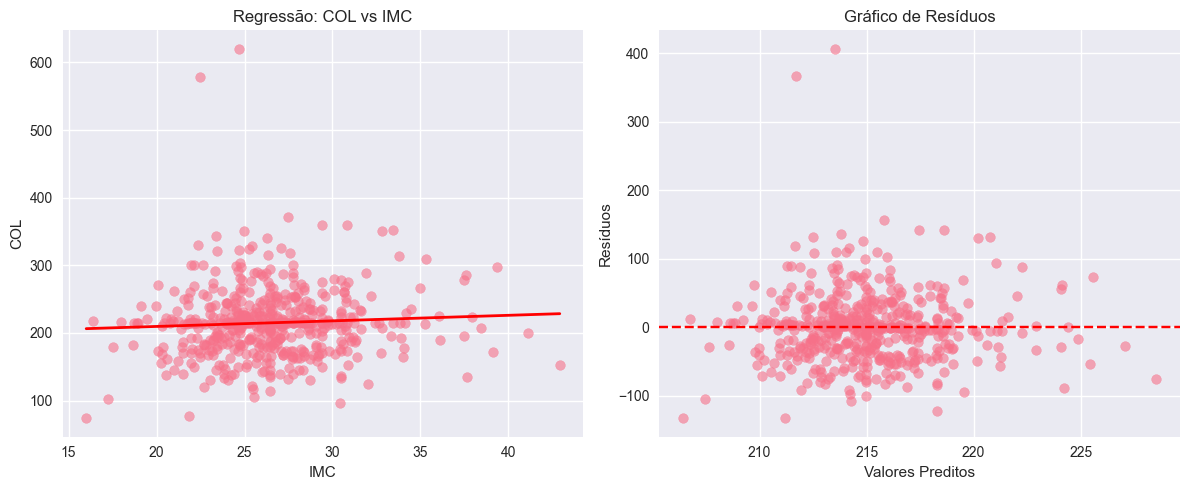


Regressão Simples: COL ~ SEXO

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    COL   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                  0.003267
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.954
Time:                        17:09:49   Log-Likelihood:                -2685.4
No. Observations:                 500   AIC:                             5375.
Df Residuals:                     498   BIC:                             5383.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

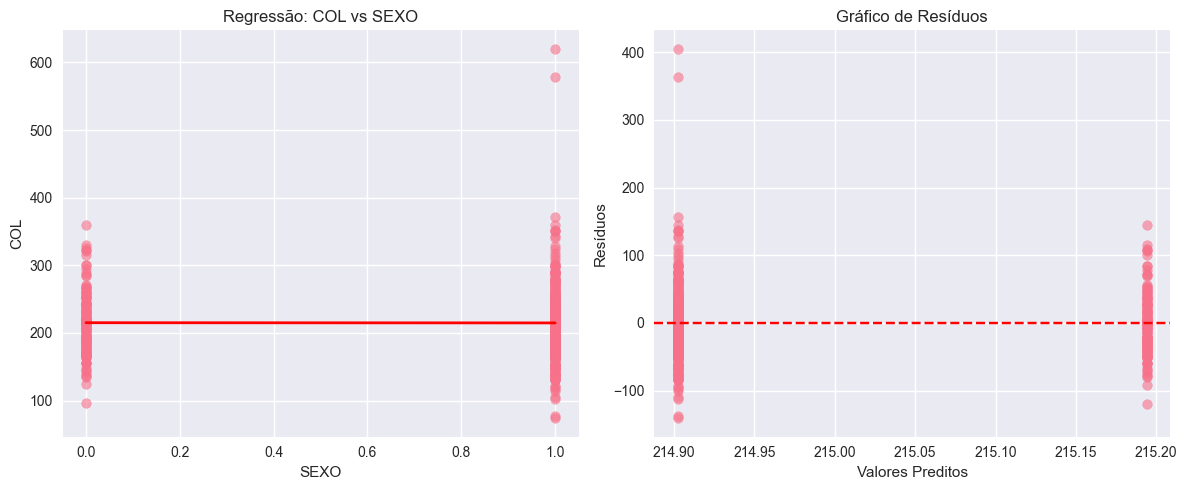


--- Valores Normalizados ---

Regressão Simples: COL ~ SEXO

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    COL   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                  0.003267
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.954
Time:                        17:09:49   Log-Likelihood:                -2685.4
No. Observations:                 500   AIC:                             5375.
Df Residuals:                     498   BIC:                             5383.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

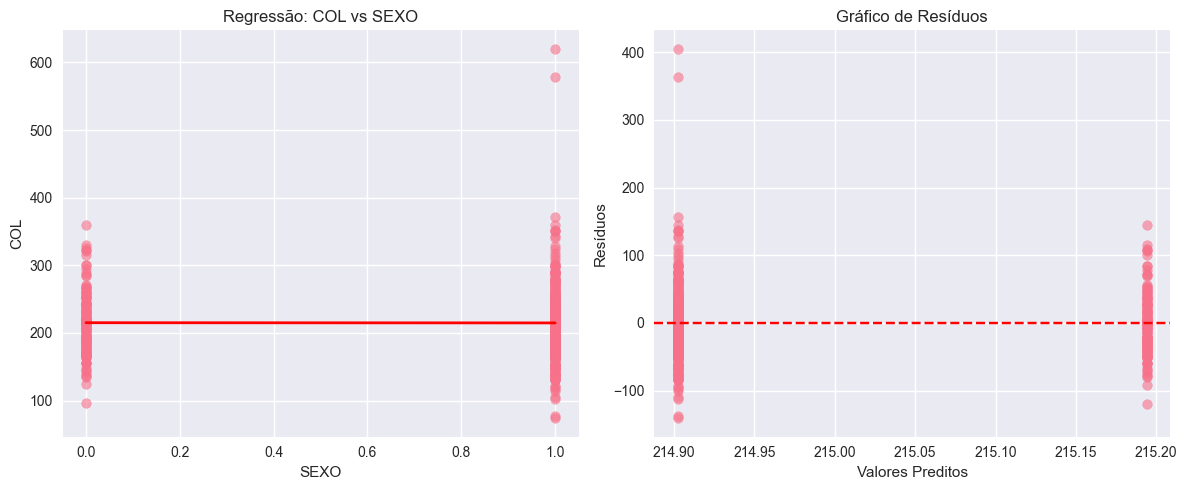


Regressão Simples: COL ~ TABAG4

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    COL   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.832
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.177
Time:                        17:09:50   Log-Likelihood:                -2684.5
No. Observations:                 500   AIC:                             5373.
Df Residuals:                     498   BIC:                             5381.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


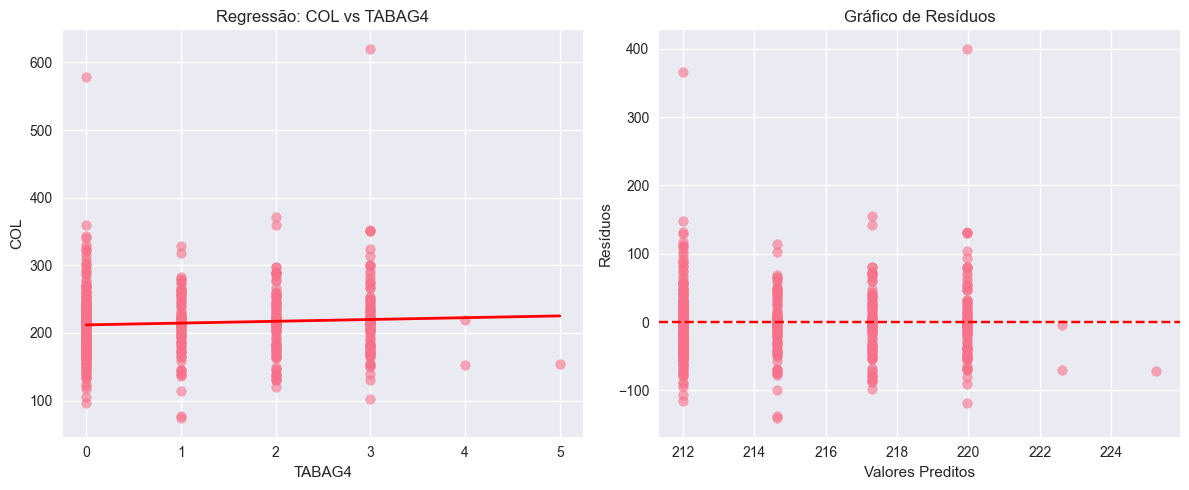


--- Valores Normalizados ---

Regressão Simples: COL ~ TABAG4

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    COL   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.832
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.177
Time:                        17:09:50   Log-Likelihood:                -2684.5
No. Observations:                 500   AIC:                             5373.
Df Residuals:                     498   BIC:                             5381.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

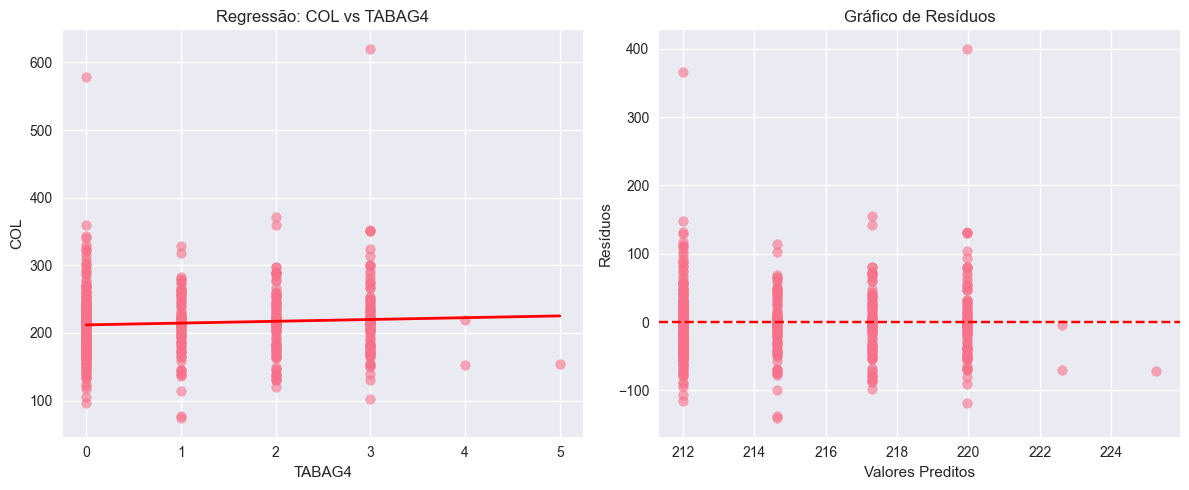


Regressão Simples: PSR ~ IDADE1

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    PSR   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     23.38
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           1.77e-06
Time:                        17:09:51   Log-Likelihood:                -1096.9
No. Observations:                 500   AIC:                             2198.
Df Residuals:                     498   BIC:                             2206.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


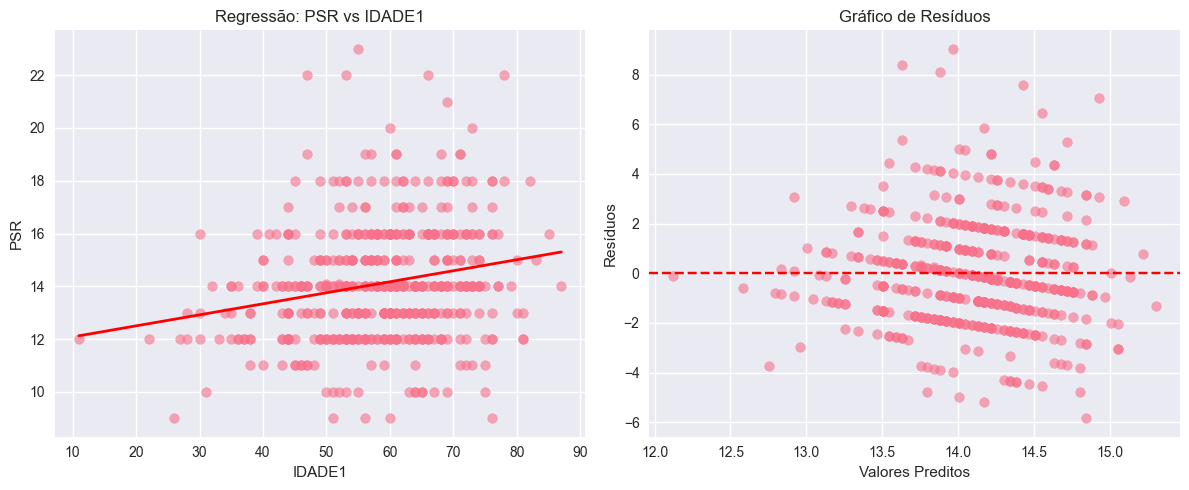


--- Valores Normalizados ---

Regressão Simples: PSR ~ IDADE1

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    PSR   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     23.38
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           1.77e-06
Time:                        17:09:52   Log-Likelihood:                -1096.9
No. Observations:                 500   AIC:                             2198.
Df Residuals:                     498   BIC:                             2206.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

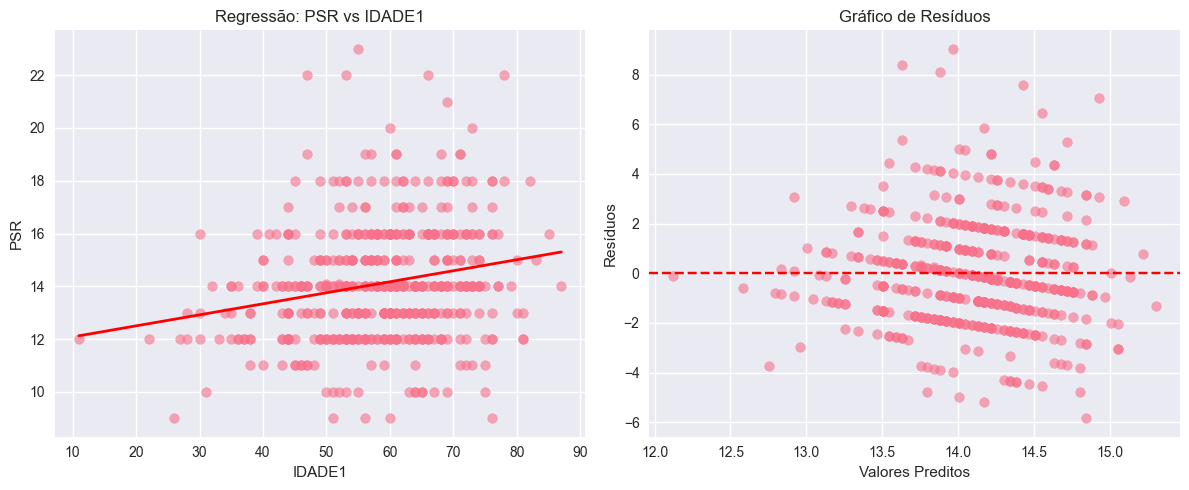


Regressão Simples: PSR ~ DIAB

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    PSR   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     4.522
Date:                Sun, 28 Sep 2025   Prob (F-statistic):             0.0339
Time:                        17:09:53   Log-Likelihood:                -1106.1
No. Observations:                 500   AIC:                             2216.
Df Residuals:                     498   BIC:                             2225.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

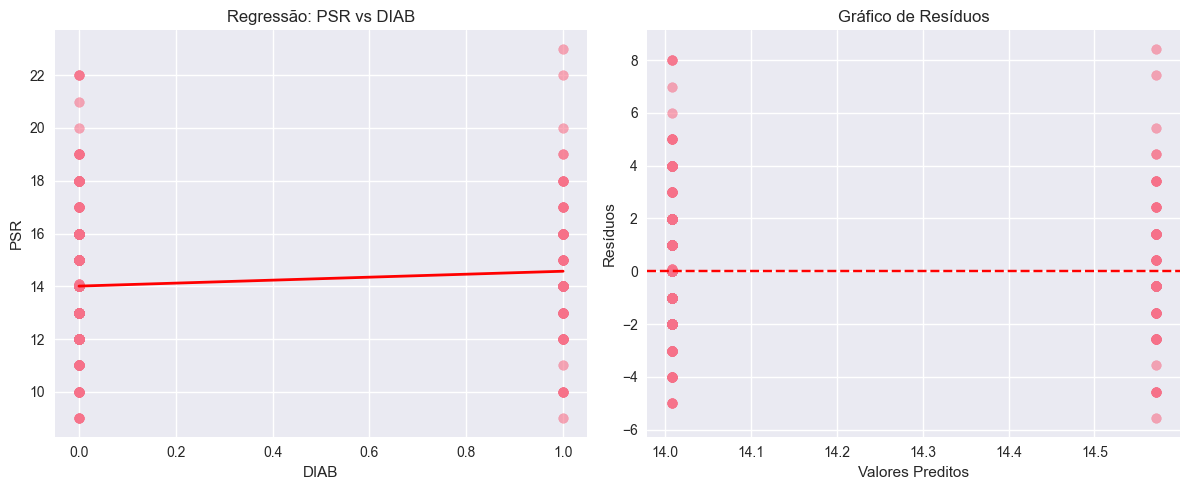


--- Valores Normalizados ---

Regressão Simples: PSR ~ DIAB

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    PSR   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     4.522
Date:                Sun, 28 Sep 2025   Prob (F-statistic):             0.0339
Time:                        17:09:54   Log-Likelihood:                -1106.1
No. Observations:                 500   AIC:                             2216.
Df Residuals:                     498   BIC:                             2225.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

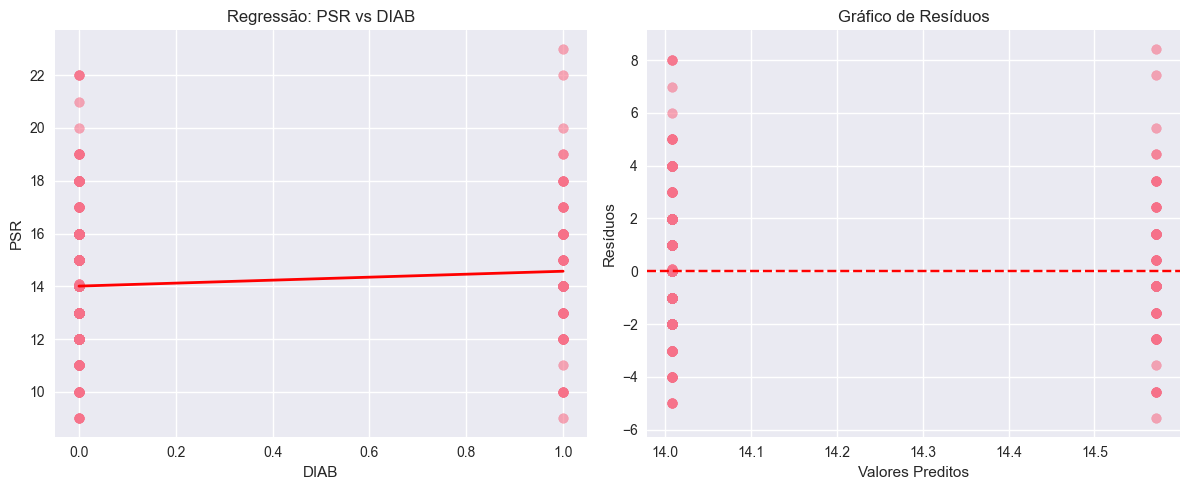


Regressão Simples: PSR ~ ARRIT

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    PSR   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4154
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.520
Time:                        17:09:55   Log-Likelihood:                -1108.2
No. Observations:                 500   AIC:                             2220.
Df Residuals:                     498   BIC:                             2229.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

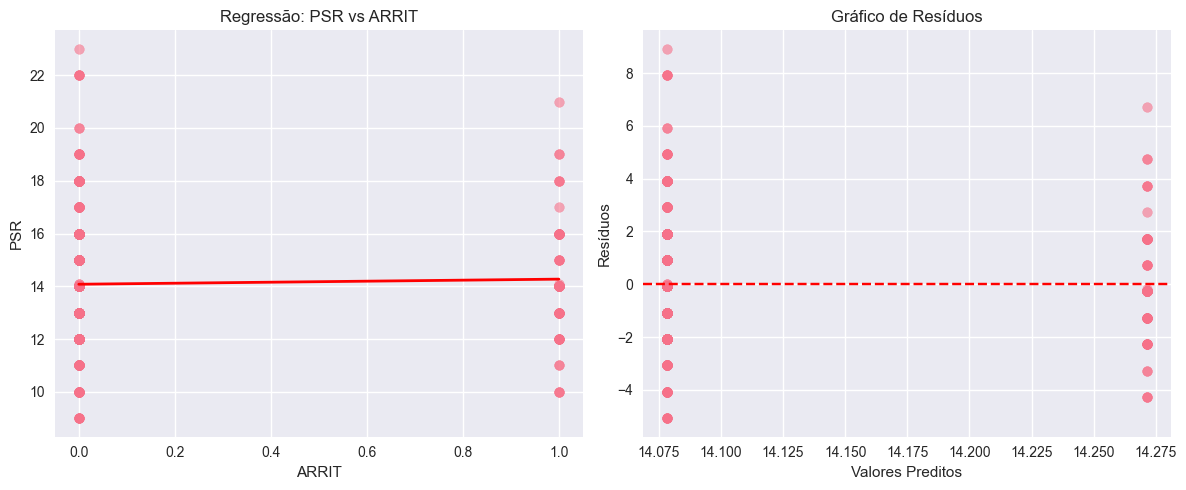


--- Valores Normalizados ---

Regressão Simples: PSR ~ ARRIT

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    PSR   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4154
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.520
Time:                        17:09:55   Log-Likelihood:                -1108.2
No. Observations:                 500   AIC:                             2220.
Df Residuals:                     498   BIC:                             2229.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

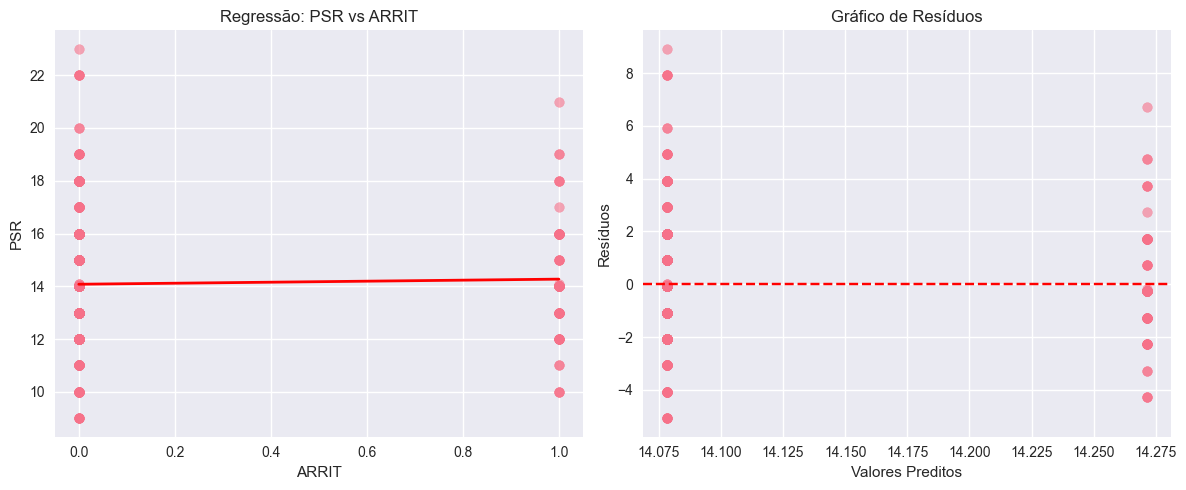


Regressão Simples: PDR ~ IDADE1

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    PDR   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.227
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.136
Time:                        17:09:56   Log-Likelihood:                -772.49
No. Observations:                 500   AIC:                             1549.
Df Residuals:                     498   BIC:                             1557.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


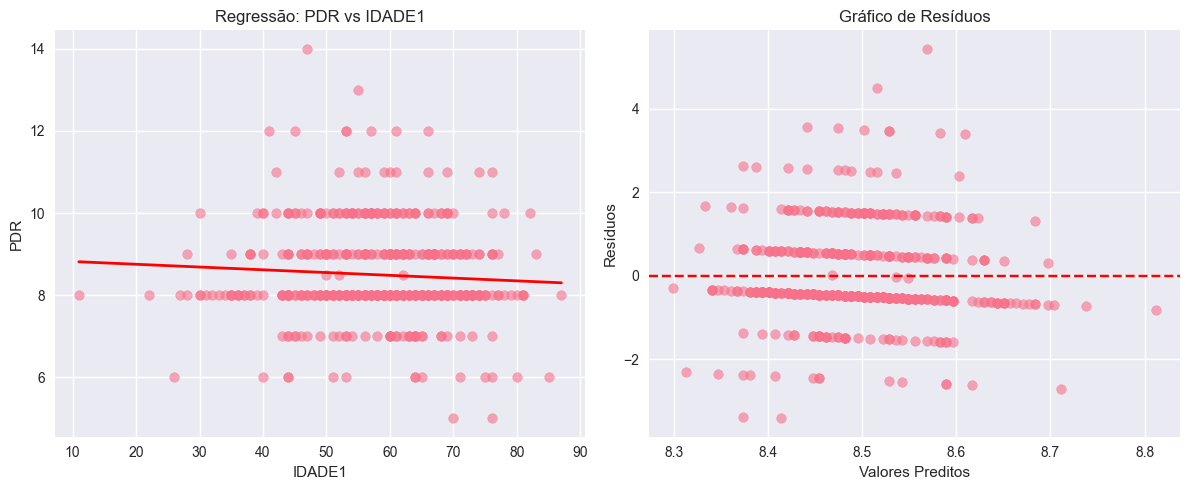


--- Valores Normalizados ---

Regressão Simples: PDR ~ IDADE1

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    PDR   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.227
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.136
Time:                        17:09:57   Log-Likelihood:                -772.49
No. Observations:                 500   AIC:                             1549.
Df Residuals:                     498   BIC:                             1557.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

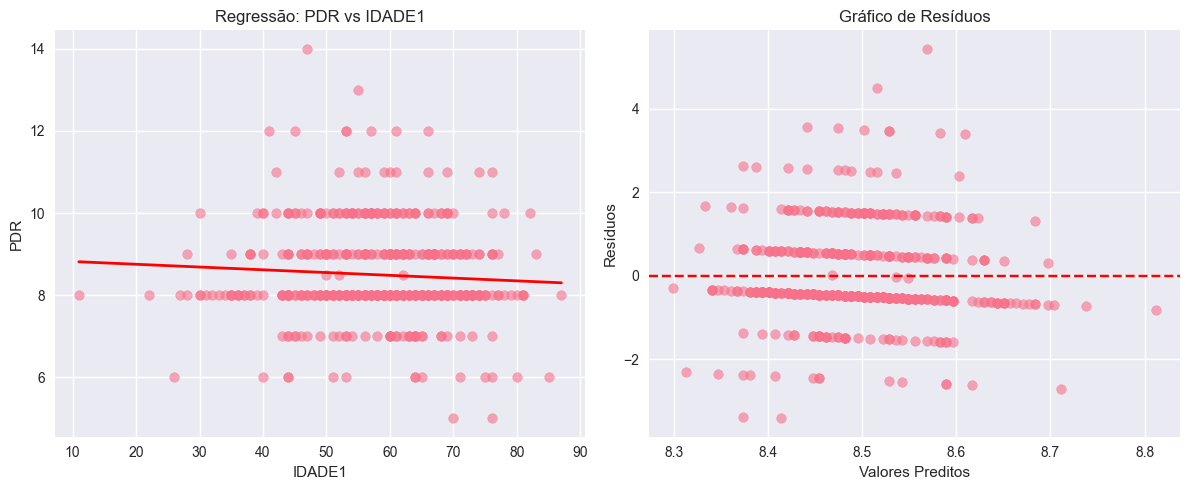


Regressão Simples: PDR ~ DIAB

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    PDR   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                  0.001840
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.966
Time:                        17:09:57   Log-Likelihood:                -773.60
No. Observations:                 500   AIC:                             1551.
Df Residuals:                     498   BIC:                             1560.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

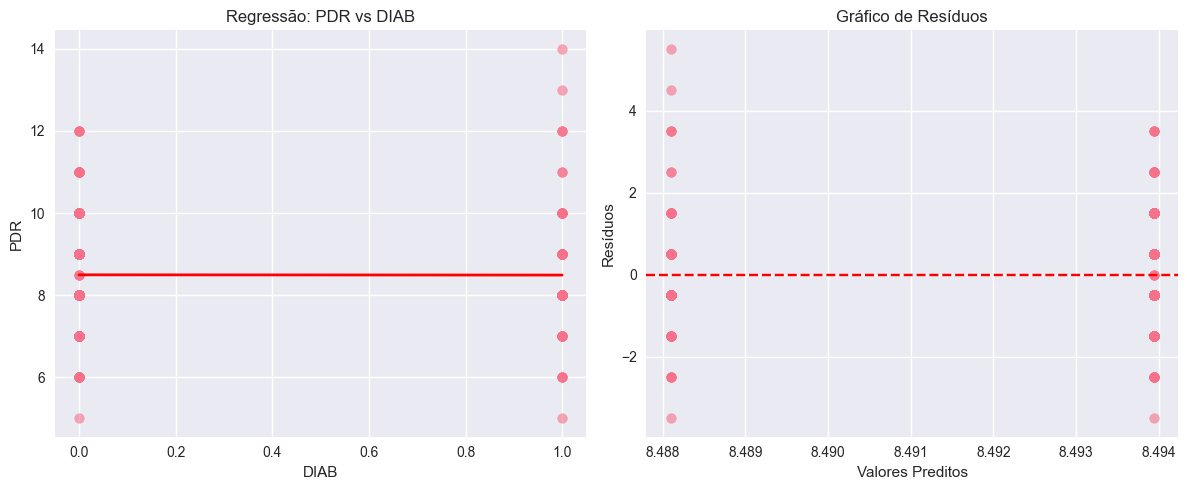


--- Valores Normalizados ---

Regressão Simples: PDR ~ DIAB

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    PDR   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                  0.001840
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.966
Time:                        17:09:58   Log-Likelihood:                -773.60
No. Observations:                 500   AIC:                             1551.
Df Residuals:                     498   BIC:                             1560.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

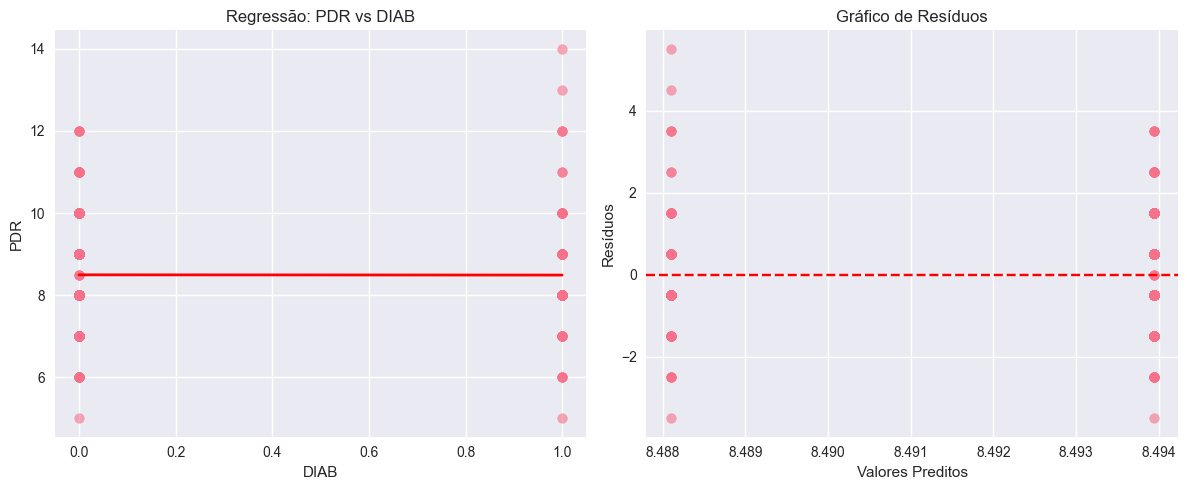


Regressão Simples: PDR ~ ARRIT

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    PDR   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6036
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.438
Time:                        17:09:59   Log-Likelihood:                -773.30
No. Observations:                 500   AIC:                             1551.
Df Residuals:                     498   BIC:                             1559.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

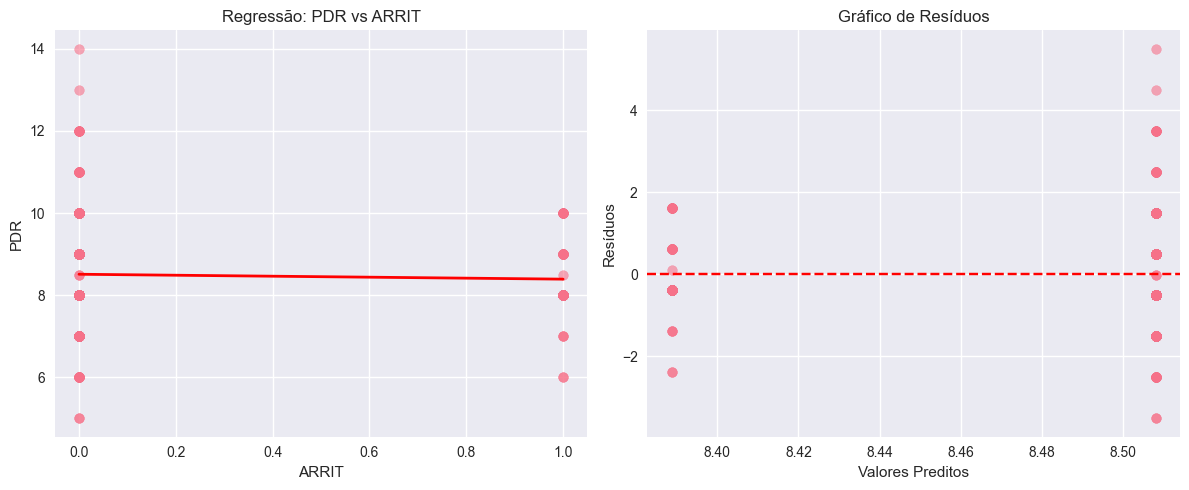


--- Valores Normalizados ---

Regressão Simples: PDR ~ ARRIT

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    PDR   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6036
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.438
Time:                        17:09:59   Log-Likelihood:                -773.30
No. Observations:                 500   AIC:                             1551.
Df Residuals:                     498   BIC:                             1559.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

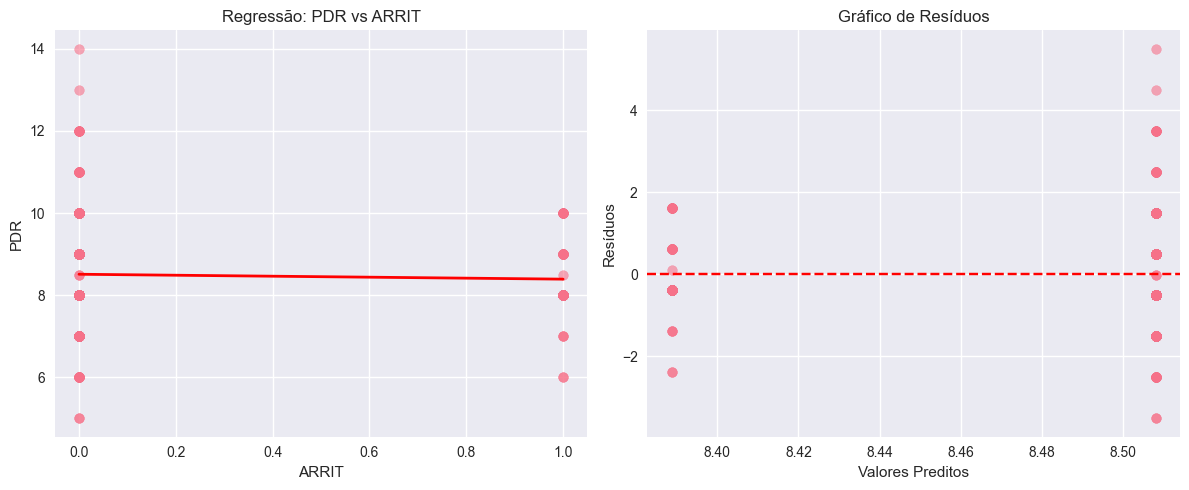

In [255]:
def regressao_simples(df, var_dependente, var_independente):
    """
    Realiza análise de regressão linear simples
    
    Parâmetros:
    - df: DataFrame
    - var_dependente: nome da variável dependente (Y)
    - var_independente: nome da variável independente (X)
    """
    
    print(f"\nRegressão Simples: {var_dependente} ~ {var_independente}")
    
    # Removendo valores nulos
    data_clean = df[[var_dependente, var_independente]].dropna()
    
    X = data_clean[var_independente]
    y = data_clean[var_dependente]
    
    # Adicionando constante para o intercept
    X_with_const = sm.add_constant(X)
    
    # Ajustando o modelo
    modelo = sm.OLS(y, X_with_const).fit()
    
    print("\nResumo do Modelo:")
    print(modelo.summary())
    
    # Correlação de Pearson
    corr, p_corr = pearsonr(X, y)
    print(f"\nCorrelação de Pearson:")
    print(f"r = {corr:.4f}, p-value = {p_corr:.6f}")
    
    # Visualização
    plt.figure(figsize=(12, 5))
    
    # Scatter plot com linha de regressão
    plt.subplot(1, 2, 1)
    plt.scatter(X, y, alpha=0.6)
    
    # Linha de regressão
    X_pred = np.linspace(X.min(), X.max(), 100)
    X_pred_const = sm.add_constant(X_pred)
    y_pred = modelo.predict(X_pred_const)
    
    plt.plot(X_pred, y_pred, 'r-', linewidth=2)
    plt.xlabel(var_independente)
    plt.ylabel(var_dependente)
    plt.title(f'Regressão: {var_dependente} vs {var_independente}')
    
    # Resíduos
    plt.subplot(1, 2, 2)
    residuos = modelo.resid
    plt.scatter(modelo.fittedvalues, residuos, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Valores Preditos')
    plt.ylabel('Resíduos')
    plt.title('Gráfico de Resíduos')
    
    plt.tight_layout()
    plt.show()
    
    return modelo

# Executando regressões simples
print("\n--- Regressões Simples ---")
modelos_simples = {}



for var_dep in an4_dep:
    for var_regressao in an4_indep:
        modelo = regressao_simples(data, var_dep, var_regressao)
        modelos_simples[f"{var_dep}_{var_regressao}"] = modelo
        print("\n--- Valores Normalizados ---")
        modelo_log = regressao_simples(df, var_dep, var_regressao)
        modelos_simples[f"{var_dep}_{var_regressao}"] = modelo_log

for var_dep in an5_dep:
    for var_regressao in an5_indep:
        modelo = regressao_simples(data, var_dep, var_regressao)
        modelos_simples[f"{var_dep}_{var_regressao}"] = modelo
        print("\n--- Valores Normalizados ---")
        modelo_log = regressao_simples(df, var_dep, var_regressao)
        modelos_simples[f"{var_dep}_{var_regressao}"] = modelo_log

for var_dep in an6_dep:
    for var_regressao in an6_indep:
        modelo = regressao_simples(data, var_dep, var_regressao)
        modelos_simples[f"{var_dep}_{var_regressao}"] = modelo
        print("\n--- Valores Normalizados ---")
        modelo_log = regressao_simples(df, var_dep, var_regressao)
        modelos_simples[f"{var_dep}_{var_regressao}"] = modelo_log



--- Regressões Múltiplas ---

Regressão Múltipla: TRIG ~ OBESO + ARTER + GLO

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                   TRIG   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.489
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.217
Time:                        17:10:00   Log-Likelihood:                -2948.9
No. Observations:                 500   AIC:                             5906.
Df Residuals:                     496   BIC:                             5923.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

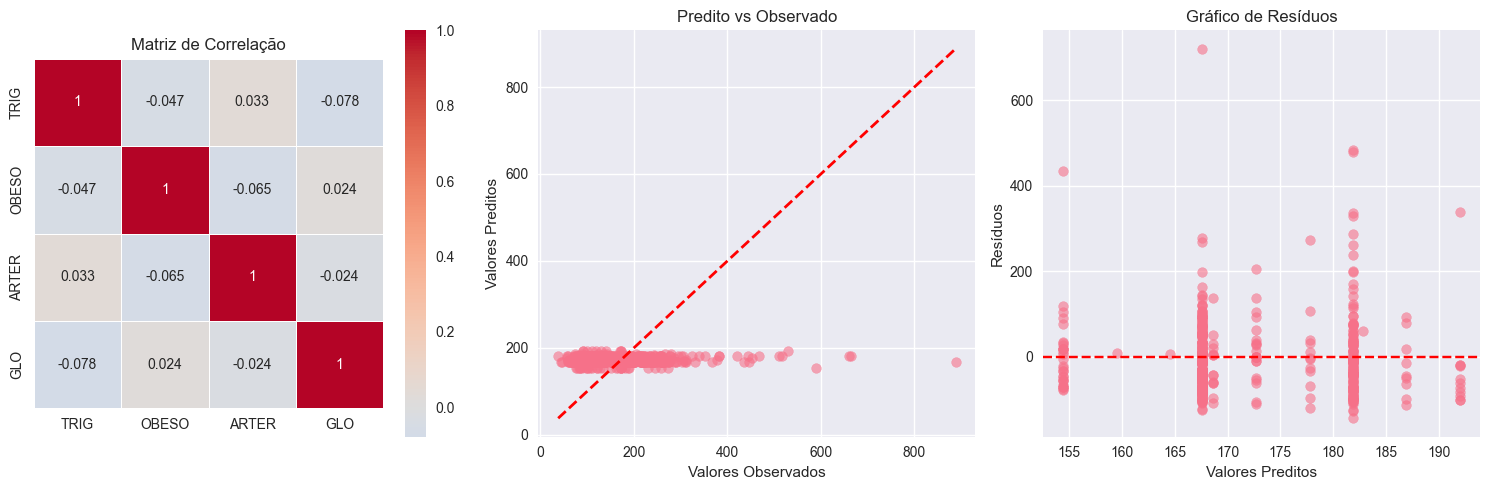


--- Diagnósticos do Modelo ---
R² = 0.0089
R² Ajustado = 0.0029
AIC = 5905.80
BIC = 5922.66

--- Valores Normalizados ---

Regressão Múltipla: TRIG ~ OBESO + ARTER + GLO

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                   TRIG   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.489
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.217
Time:                        17:10:01   Log-Likelihood:                -2948.9
No. Observations:                 500   AIC:                             5906.
Df Residuals:                     496   BIC:                             5923.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coe

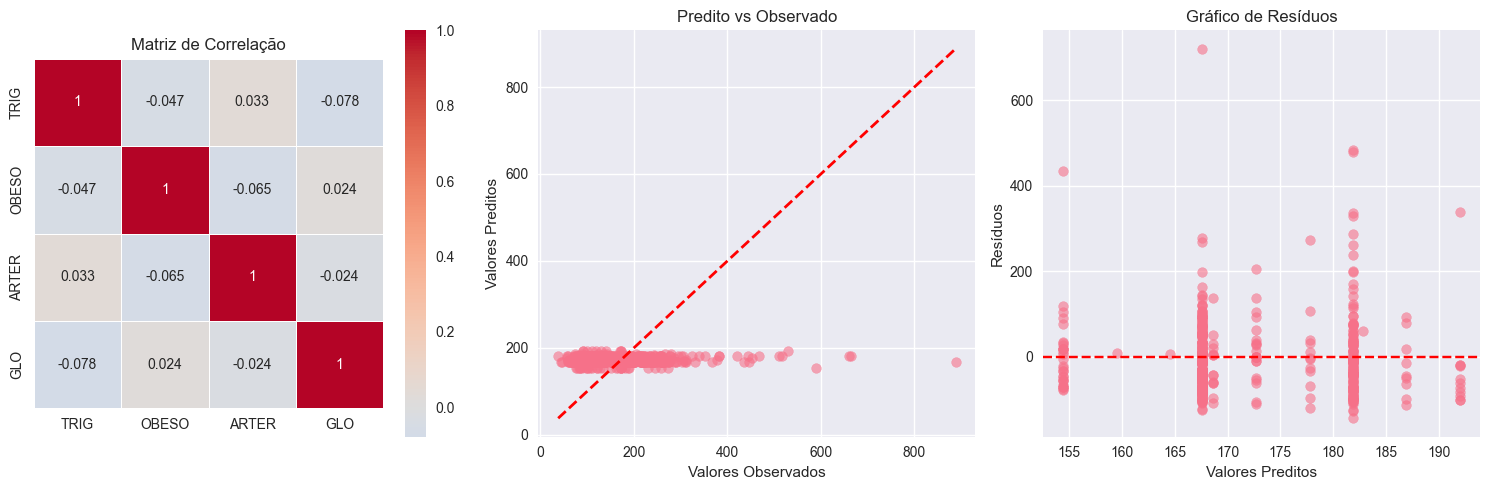


--- Diagnósticos do Modelo ---
R² = 0.0089
R² Ajustado = 0.0029
AIC = 5905.80
BIC = 5922.66

Regressão Múltipla: COL ~ TRIG + IMC + SEXO + TABAG4

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    COL   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     28.88
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           1.35e-21
Time:                        17:10:02   Log-Likelihood:                -2633.0
No. Observations:                 500   AIC:                             5276.
Df Residuals:                     495   BIC:                             5297.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t 

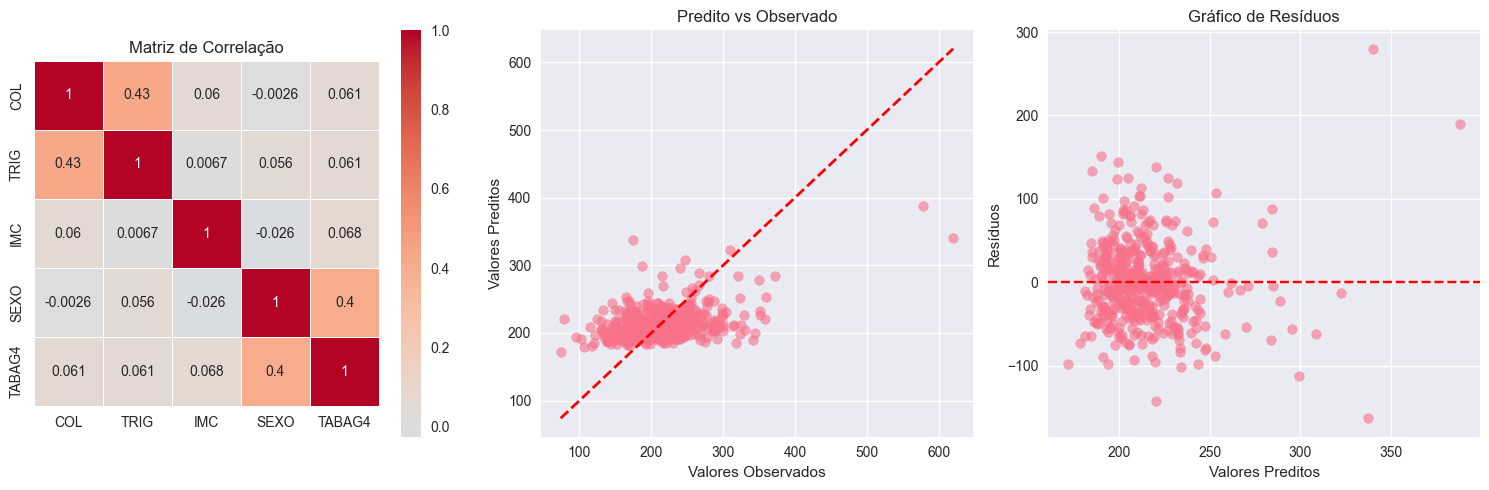


--- Diagnósticos do Modelo ---
R² = 0.1892
R² Ajustado = 0.1827
AIC = 5275.96
BIC = 5297.04

--- Valores Normalizados ---

Regressão Múltipla: COL ~ TRIG + IMC + SEXO + TABAG4

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    COL   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     28.88
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           1.35e-21
Time:                        17:10:04   Log-Likelihood:                -2633.0
No. Observations:                 500   AIC:                             5276.
Df Residuals:                     495   BIC:                             5297.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
              

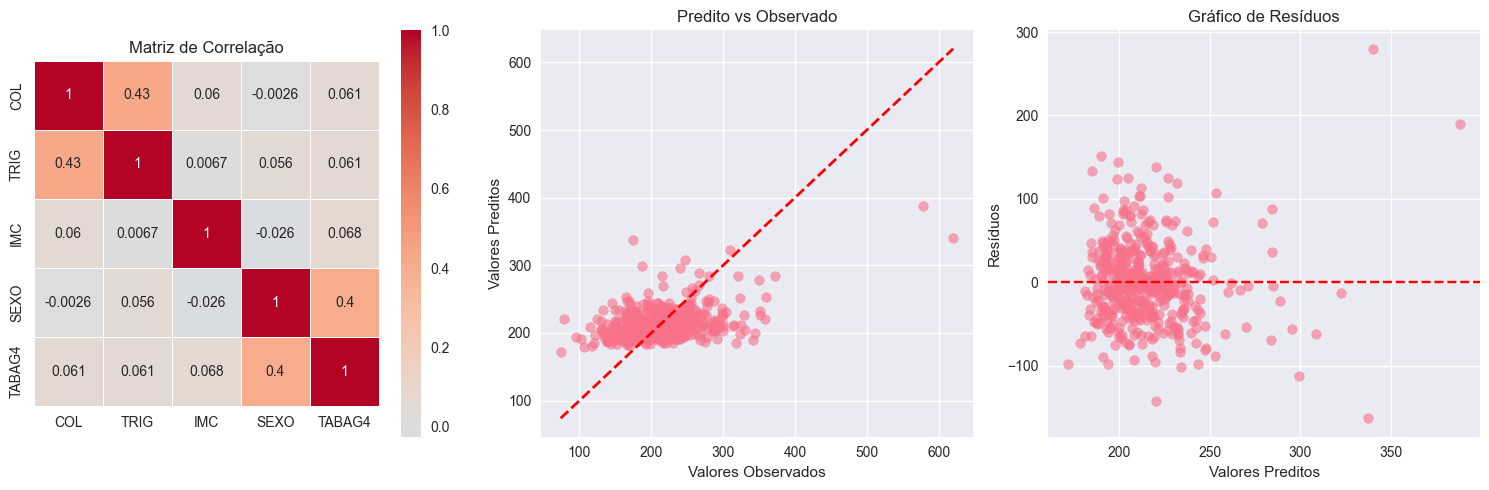


--- Diagnósticos do Modelo ---
R² = 0.1892
R² Ajustado = 0.1827
AIC = 5275.96
BIC = 5297.04

Regressão Múltipla: PSR ~ IDADE1 + DIAB + ARRIT

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    PSR   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     8.682
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           1.27e-05
Time:                        17:10:06   Log-Likelihood:                -1095.6
No. Observations:                 500   AIC:                             2199.
Df Residuals:                     496   BIC:                             2216.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

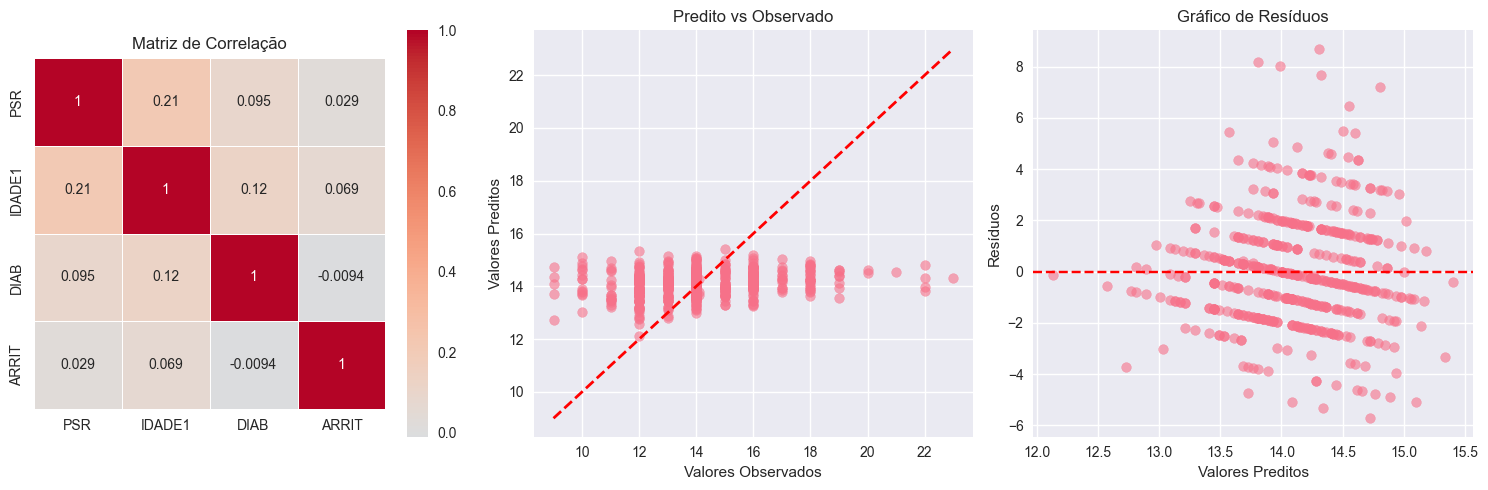


--- Diagnósticos do Modelo ---
R² = 0.0499
R² Ajustado = 0.0441
AIC = 2199.18
BIC = 2216.03

--- Valores Normalizados ---

Regressão Múltipla: PSR ~ IDADE1 + DIAB + ARRIT

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    PSR   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     8.682
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           1.27e-05
Time:                        17:10:08   Log-Likelihood:                -1095.6
No. Observations:                 500   AIC:                             2199.
Df Residuals:                     496   BIC:                             2216.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 co

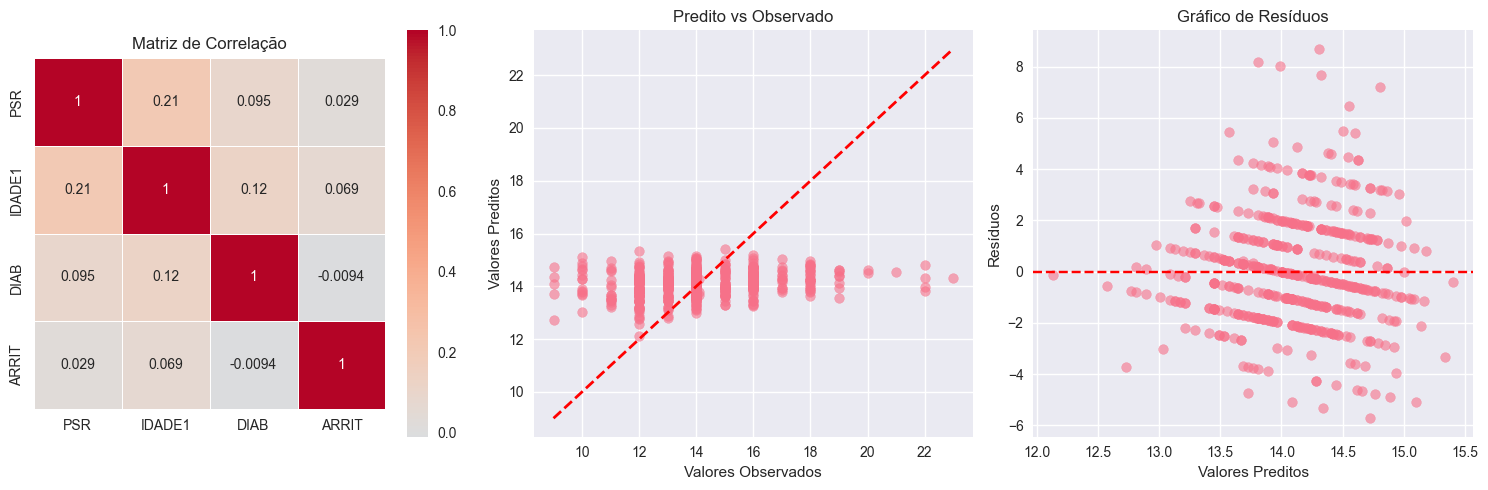


--- Diagnósticos do Modelo ---
R² = 0.0499
R² Ajustado = 0.0441
AIC = 2199.18
BIC = 2216.03

Regressão Múltipla: PDR ~ IDADE1 + DIAB + ARRIT

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    PDR   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8977
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.442
Time:                        17:10:09   Log-Likelihood:                -772.25
No. Observations:                 500   AIC:                             1553.
Df Residuals:                     496   BIC:                             1569.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

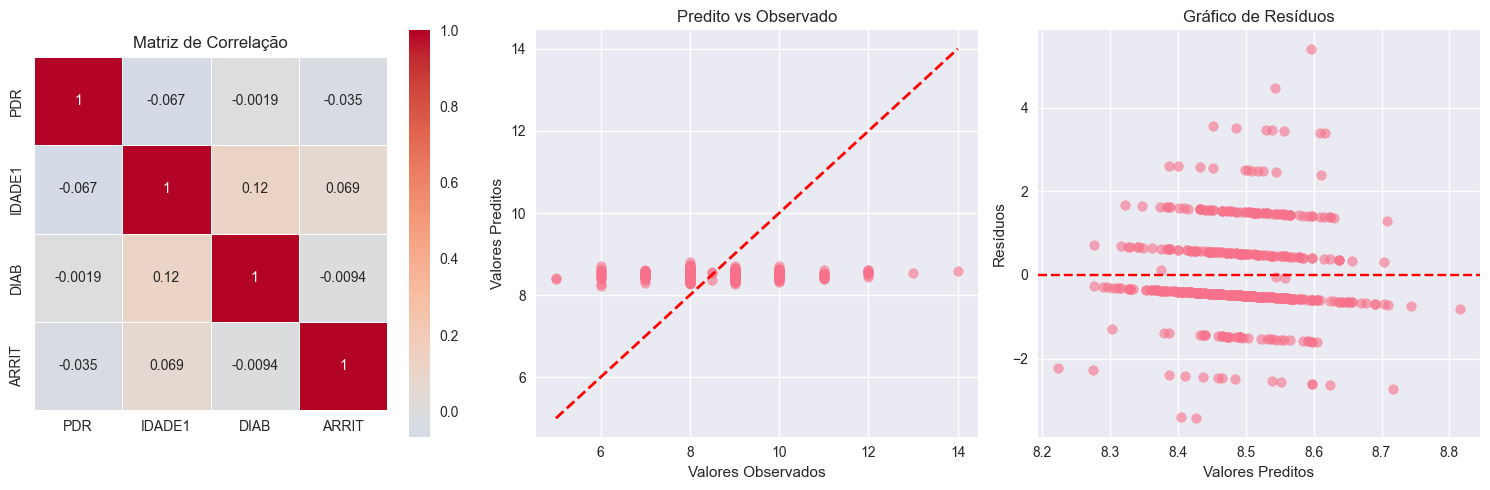


--- Diagnósticos do Modelo ---
R² = 0.0054
R² Ajustado = -0.0006
AIC = 1552.50
BIC = 1569.36

--- Valores Normalizados ---

Regressão Múltipla: PDR ~ IDADE1 + DIAB + ARRIT

Resumo do Modelo:
                            OLS Regression Results                            
Dep. Variable:                    PDR   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8977
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.442
Time:                        17:10:11   Log-Likelihood:                -772.25
No. Observations:                 500   AIC:                             1553.
Df Residuals:                     496   BIC:                             1569.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 c

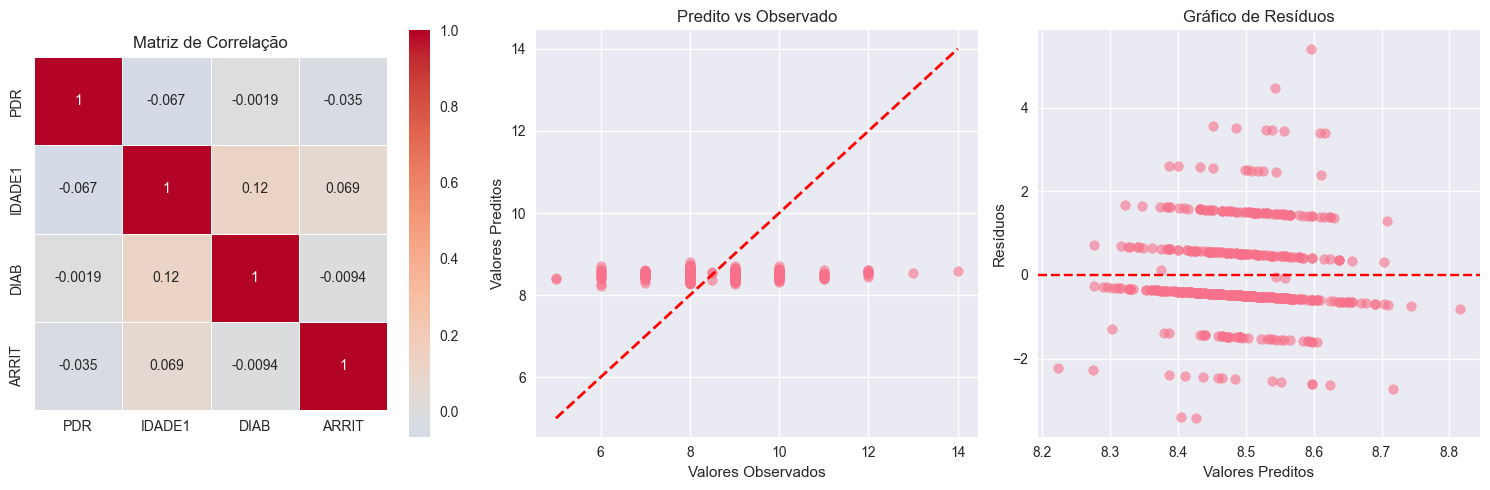


--- Diagnósticos do Modelo ---
R² = 0.0054
R² Ajustado = -0.0006
AIC = 1552.50
BIC = 1569.36


In [256]:
def regressao_multipla(df, var_dependente, vars_independentes):
    """
    Realiza análise de regressão linear múltipla
    
    Parâmetros:
    - df: DataFrame
    - var_dependente: nome da variável dependente (Y)
    - vars_independentes: lista com nomes das variáveis independentes (X)
    """
    
    print(f"\nRegressão Múltipla: {var_dependente} ~ {' + '.join(vars_independentes)}")
    
    # Preparando os dados
    vars_all = [var_dependente] + vars_independentes
    data_clean = df[vars_all].dropna()
    
    X = data_clean[vars_independentes]
    y = data_clean[var_dependente]
    
    # Adicionando constante
    X_with_const = sm.add_constant(X)
    
    # Ajustando o modelo
    modelo = sm.OLS(y, X_with_const).fit()
    
    print("\nResumo do Modelo:")
    print(modelo.summary())
    
    # Matriz de correlação
    corr_matrix = data_clean[vars_all].corr()
    
    plt.figure(figsize=(15, 5))
    
    # Heatmap de correlação
    plt.subplot(1, 3, 1)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5)
    plt.title('Matriz de Correlação')
    
    # Valores preditos vs observados
    plt.subplot(1, 3, 2)
    y_pred = modelo.fittedvalues
    plt.scatter(y, y_pred, alpha=0.6)
    
    # Linha de referência (predição perfeita)
    min_val = min(y.min(), y_pred.min())
    max_val = max(y.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    
    plt.xlabel('Valores Observados')
    plt.ylabel('Valores Preditos')
    plt.title('Predito vs Observado')
    
    # Resíduos
    plt.subplot(1, 3, 3)
    residuos = modelo.resid
    plt.scatter(y_pred, residuos, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Valores Preditos')
    plt.ylabel('Resíduos')
    plt.title('Gráfico de Resíduos')
    
    plt.tight_layout()
    plt.show()
    
    # Diagnósticos do modelo
    print("\n--- Diagnósticos do Modelo ---")
    print(f"R² = {modelo.rsquared:.4f}")
    print(f"R² Ajustado = {modelo.rsquared_adj:.4f}")
    print(f"AIC = {modelo.aic:.2f}")
    print(f"BIC = {modelo.bic:.2f}")
    
    return modelo

# Executando regressões múltiplas
print("\n--- Regressões Múltiplas ---")
modelos_multiplos = {}

for var_dep in an4_dep:
    modelo = regressao_multipla(data, var_dep, an4_indep)
    modelos_multiplos[var_dep] = modelo
    print("\n--- Valores Normalizados ---")
    modelo = regressao_multipla(df, var_dep, an4_indep)
    modelos_multiplos[var_dep] = modelo

for var_dep in an5_dep:
    modelo = regressao_multipla(data, var_dep, an5_indep)
    modelos_multiplos[var_dep] = modelo
    print("\n--- Valores Normalizados ---")
    modelo = regressao_multipla(df, var_dep, an5_indep)
    modelos_multiplos[var_dep] = modelo

for var_dep in an6_dep:
    modelo = regressao_multipla(data, var_dep, an6_indep)
    modelos_multiplos[var_dep] = modelo
    print("\n--- Valores Normalizados ---")
    modelo = regressao_multipla(df, var_dep, an6_indep)
    modelos_multiplos[var_dep] = modelo